# Supermarket Sales - Predição da nota de avaliação do cliente
### Matheus Antonio Alves de Araujo - 2016040207 
### Aprendizagem de Máquina DE-UFPB

##### Descrição da base de dados da fonte adquirida.
- O crescimento dos supermercados nas cidades mais populosas está aumentando e as competições de mercado também são altas. O conjunto de dados se baseia nas vendas históricas da uma determinada empresa de supermercados que registrou dados em 3 filiais diferentes por 3 meses. Os métodos de análise preditiva de dados são fáceis de aplicar com este conjunto de dados.

##### Requisoção do projeto
- Desenvolver uma solução de aprendizagem de máquina. Deve ser desenvolvido um workflow de aprendizagem de máquina, contemplando análise exploratória dos dados, pré-processamento e feature engineering, treinamento dos modelos, escolha do melhor modelo e avaliação no conjunto de teste.

- Para conjunto de dados Supermarket Sales, a tarefa consiste em predizer a nota que os clientes atribuem à sua experiência de compra (Variável resposta "Rating")


### 0.0 Imports

###### É feito o carregamento dos módulos e funções de interesse para o estudo

In [101]:
import warnings

import numpy   as np
import pandas  as pd
import seaborn as sns

from scipy      import stats  as ss
from matplotlib import pyplot as plt

from boruta                    import BorutaPy  
from xgboost                   import XGBRegressor
from datetime                  import datetime
from sklearn.svm               import SVR
from sklearn.tree              import DecisionTreeRegressor
from sklearn.metrics           import r2_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics           import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.ensemble          import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model      import LinearRegression, Lasso, Ridge
from sklearn.decomposition     import PCA
from sklearn.preprocessing     import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.neural_network    import MLPRegressor, MLPClassifier
from sklearn.model_selection   import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.feature_selection import RFE, SelectKBest, f_regression

sns.set()
warnings.filterwarnings( 'ignore' )

### 0.1 Funções Auxiliares
###### Funções utilizadas no decorrer do workflow
###### As funções são criadas no intuito de diminuir a escrita de código, onde basta chamar a função que será retornado o resultado pre definido para casos generalizados. Dessa forma evita ter que estruturar todo o processo para os casos específicos.

In [108]:
#Função para exibir algumas medidas descritivas dos dados

def summary(data): #Recebe dataset como argumento
    numerical = data.select_dtypes(include=['int64','float64']) #Seleciona os dados do tipo inteiro e ponto flutuante
    df_min = pd.DataFrame(numerical.apply(min)).T #Calcula o Minimo
    df_max = pd.DataFrame(numerical.apply(max)).T #Calcula o Máximo
    df_range = pd.DataFrame(numerical.apply(lambda x: x.max()-x.min())).T #Calcula a amplitude
    df_median = pd.DataFrame(numerical.apply(np.median)).T#Calcula a mediana
    df_mean = pd.DataFrame(numerical.apply(np.mean)).T #Calcula a media
    df_std = pd.DataFrame(numerical.apply(np.std)).T #Calcula o desvio padrão
    df_skew = pd.DataFrame(numerical.apply(lambda x: x.skew())).T #Calcula a assimetria
    df_kurt = pd.DataFrame(numerical.apply(lambda x: x.kurtosis())).T #Calcula a curtose
    
    summary = pd.concat([df_min,df_max,df_range,df_median,df_mean,df_std,df_skew,df_kurt]).T #concatena as listas/vetores em um dataframe e aplica a transposta 
    summary.columns = ['Min','Max','Range','Median','Mean','Standard Deviation','Skewness','Kurtosis'] #renomeia as colunas do dataframe
    
    return summary #Retorna o dataframe com as medidas 

#Função para calcular V de Cramer
def cramer_v( x, y ): 
    cm = np.matrix(pd.crosstab( x, y )) #gera matrix de confusão para os vetores passados 
    n = cm.sum() #aplica a soma nas colunas
    r, k = cm.shape #r recebe o numero de linhas e k o numero de colunas 
    chi2 = ss.chi2_contingency( cm )[0] #chi2 recebe o valor da estatistica qui quadrado da matriz gerada
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) #retorna o maximo da quantia expressada (utilizado na fórmula)
    kcorr = k - (k-1)**2/(n-1) #rcorr recebe a correlação entre as colunas
    rcorr = r - (r-1)**2/(n-1) #rcorr recebe a correlação entre as linhas
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) ) #retorna o estimador Cramer V

#Função para retornar erros compilados em um dataframe  
def ml_error( model_name, y, yhat ): #recebe o nome do modelo, y de teste e y predito onde são passados para as funções de erro 
    mae = mean_absolute_error( y, yhat ) #calcula o erro absoluto médio
    mape = mean_absolute_percentage_error( y, yhat ) #calcula o erro percentual absoluto médio
    mse = mean_squared_error(y,yhat) #calcula o erro quadrado médio
    rmse = np.sqrt(mse) #calcula a raiz do erro quadrado médio 
    R2 = r2_score(y, yhat)  #calcula o R quadrado 
    return pd.DataFrame( { 'Nome do Modelo': model_name,   #Converte o dicionário em dataframe, onde a chave é a coluna e os valores são as linhas
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse,
                           'R-quadrado': R2}, 
                           index=[0] )

#Função que realiza validação cruzada K-Folds para o modelo passado, retorno a média dos erros compilados em um dataframe  
def validacao_cruzada(model,x,y,kfolds):
    kfold = KFold(n_splits=kfolds, shuffle=True) #ajusta o construtor do kfold
    
    r2 = cross_val_score(model, x, y, cv = kfold) #retorno o r2 quadrado de cada fold
    mae_cv = cross_val_score(model, x, y,scoring='neg_mean_absolute_error', cv = kfold) #retorno o MAE negativo de cada fold
    mape_cv = cross_val_score(model, x, y,scoring='neg_mean_absolute_percentage_error', cv = kfold) #retorno a MAPE negativo de cada fold
    rmse_cv = cross_val_score(model, x, y,scoring='neg_root_mean_squared_error', cv = kfold) #retorno o RMSE negativo de cada fold

    return pd.DataFrame( { 'Validação Cruzada': 'Média dos kfolds', #Converte o dicionário em dataframe, onde a chave é a coluna e os valores são as linhas
                           'MAE': abs(mae_cv).mean(), #aplica o módulo na medida pois o score retornado na função é negativo. Calcula a média em seguida
                           'MAPE': abs(mape_cv).mean(),#aplica o módulo na medida pois o score retornado na função é negativo. Calcula a média em seguida
                           'RMSE': abs(rmse_cv).mean(),#aplica o módulo na medida pois o score retornado na função é negativo. Calcula a média em seguida
                           'R-quadrado': r2.mean()}, #aplica o módulo na medida pois o score retornado na função é negativo. Calcula a média em seguida
                           index=[0] ) 


### 0.2 Leitura dos dados

In [57]:
dados = pd.read_csv('supermarket_sales.csv') #lendo arquivo com biblioteca pandas apelidada de pd
dados.head() #Chama as primeiras 6 linhas do dataframe (cabeçalho incluído)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


###### Podemos observar que são 17 variáveis apresentadas onde:

- **Invoice ID**: Representa o número de identificação do cliente
- **Branch**: Rótulo da filial (existem 3 no dataset [A,B,C])
- **City**: Cidade onde fica localizada a filial, cada uma das 3 fica em uma cidade diferente, logo Branch e City serão equivalentes
- **Cutymer type**: Tipo de clienete, se é 'Membro' de algum serviço ou 'Normal' se é um cliente ocasional.
- **Gender**: Sexo do cliente
- **Product line**: Categoria do produto comprado pelo cliente
- **Unit price**: Preço unitário (se comprou 7 items, o valor de cada um)
- **Tax 5%**: Imposto americano sobre a aquisição, de 5% do valor.
- **Total**: Preço final pago (inlcuindo imposto)
- **Date**: Data da compra (De janeiro de 2019 a março de 2019)
- **Time**: Hora da compra (10h às 21h)
- **Payment**: Forma de pagamento utilizado pelo cliente (3 métodos estão disponíveis – Dinheiro, Cartão de Crédito e Ewallet)
- **cogs**: Custo da mercadoria vendida
- **gross margin percentage**: Porcentagem de margem de lucro
- **gross income**: Receita bruta
- **Rating**: Avaliação do cliente em sua experiência geral de compra (em uma escala de 1 a 10)

## 1.0 Análise Exploratória dos Dados

### 1.1 Renomeando as colunas 

###### É realizado o renomeamento das colunas para facilitar o manuseamento das mesmas 

In [58]:
#Renomeando colunas como snake_case
dados.columns = map(str.lower, dados.columns) #aplica caixa baixa nos caracteres
dados = dados.rename(columns=lambda x: x.replace(" ",'_')) #substitui espaço em branco por underline
dados.columns #exibe nome das colunas do dataframe

Index(['invoice_id', 'branch', 'city', 'customer_type', 'gender',
       'product_line', 'unit_price', 'quantity', 'tax_5%', 'total', 'date',
       'time', 'payment', 'cogs', 'gross_margin_percentage', 'gross_income',
       'rating'],
      dtype='object')

### 1.2 Dimensão dos dados

###### Podemos observar que o dataset contém mil observações  e um total de dezessete variáveis 

In [59]:
print(f'O número de observações é: {dados.shape[0]}') #exibe a string formatada com o valor do número de linhas do dataframe
print(f'O número de variáveis é: {dados.shape[1]}') #exibe a string formatada com o valor do número de colunas do dataframe

O número de observações é: 1000
O número de variáveis é: 17


### 1.3 Checando os NA's

###### As variáveis não apresentam informações faltantes, com isso não será necessario adicionar etapas de substituição no data cleaning.

In [6]:
dados.isna().sum() #Verifica se o valor é na para todas observações e aplica a soma para os casos verdadeiros, retornando a soma total de NA em cada coluna 
#dados sem NA's
# dados.info()

invoice_id                 0
branch                     0
city                       0
customer_type              0
gender                     0
product_line               0
unit_price                 0
quantity                   0
tax_5%                     0
total                      0
date                       0
time                       0
payment                    0
cogs                       0
gross_margin_percentage    0
gross_income               0
rating                     0
dtype: int64

### 1.4 Tipos dos dados

###### Observa-se que os dados são em grande parte categóricas já apontando que será necessario transformá-los para serem adicionados na modelagem. A variável de data está apresentada como string, na linguagem python é necessario converte-la para o tipo datetime para que possamos trabalhar com as mesmas de forma mais tranquila.

In [7]:
dados.dtypes #exibe o nome da coluna e o tipo de dado 

invoice_id                  object
branch                      object
city                        object
customer_type               object
gender                      object
product_line                object
unit_price                 float64
quantity                     int64
tax_5%                     float64
total                      float64
date                        object
time                        object
payment                     object
cogs                       float64
gross_margin_percentage    float64
gross_income               float64
rating                     float64
dtype: object

### 1.5 Alterando variável 'date' para tipo datetime.

###### Foi feita a conversão para datetime 

In [8]:
# Convertendo variável 'date' para tipo datetime
dados['date'] = pd.to_datetime(dados['date']) #converte do tipo object para datetime64

### 1.6 Estatística Descritiva

###### Para trabalharmos de forma mais organizada, é interessante fazer a separação dos dados numéricos e dos categóricas

In [9]:
#Variaveis numéricas e categoricas
numerical = dados.select_dtypes(include=['int64','float64']) #objeto 'numerical' recebe as colunas do tipo inteiro e ponto flutuante
categorical = dados.select_dtypes(exclude=['int64','float64']) #objeto 'categorical' recebe as colunas do tipo diferentes de inteiro e ponto flutuante

#### 1.6.1 Variáveis Numéricas

###### Para visualizarmos algumas medidas descritivas dos dados numéricos, podemos utilizar a função summary

In [10]:
#Aplicando a função summary nos dados (criada na seção 0.1)
summary(dados)

,Min,Max,Range,Median,Mean,Standard Deviation,Skewness,Kurtosis
unit_price,10.080000,99.960000,89.8800,55.230000,55.672130,2.648138e+01,0.007077,-1.218591
quantity,1.000000,10.000000,9.0000,5.000000,5.510000,2.921969e+00,0.012941,-1.215547
tax_5%,0.508500,49.650000,49.1415,12.088000,15.379369,1.170297e+01,0.892570,-0.081885
total,10.678500,1042.650000,1031.9715,253.848000,322.966749,2.457624e+02,0.892570,-0.081885
cogs,10.170000,993.000000,982.8300,241.760000,307.587380,2.340594e+02,0.892570,-0.081885
gross_margin_percentage,4.761905,4.761905,0.0000,4.761905,4.761905,6.128431e-14,0.000000,0.000000
gross_income,0.508500,49.650000,49.1415,12.088000,15.379369,1.170297e+01,0.892570,-0.081885
rating,4.000000,10.000000,6.0000,7.000000,6.972700,1.717721e+00,0.009010,-1.151587


Com o retorno da função, podemos ter um entendimento inicial da descrição dos dados. Oberva-se a priori que as variáveis tem medidas centrais proximas, as extremidades são coerentes com a aplitude não indicando presença de outliers, o desvio é controlado. Todas possuem densidade com assimetria à esquerda e curtose 'achatada' apesar de próxima à média.

#### 1.6.2 Variáveis Categóricas

###### Para as variáveis categóricas, podemos inicialmente observar seus níveis 

In [11]:
# Mostra os níveis das variáveis categóricas
print(categorical.apply(lambda x: x.unique().shape[0])) #Função lambda verifica valores unicos para cada observação em 'categorical' e retorno o número de linhas 
pd.set_option('max_colwidth', 400) #configura a largura exibida do dataframe
pd.DataFrame({"Níveis das Variáveis":categorical[['branch','city','customer_type','gender','product_line','payment']].apply(lambda x: x.unique())}) 
#converte o dicionário em data frame 



invoice_id       1000
branch              3
city                3
customer_type       2
gender              2
product_line        6
date               89
time              506
payment             3
dtype: int64


,Níveis das Variáveis
branch,"[A, C, B]"
city,"[Yangon, Naypyitaw, Mandalay]"
customer_type,"[Member, Normal]"
gender,"[Female, Male]"
product_line,"[Health and beauty, Electronic accessories, Home and lifestyle, Sports and travel, Food and beverages, Fashion accessories]"
payment,"[Ewallet, Cash, Credit card]"


A variável branch e city, como comentado inicialmente, são equivalentes no sentido de fornecerem o mesmo grau de informação. As demais variáveis estão coerentes com a descrição do banco de dados, apresentando apenas valores esperados sem anomalias.

###### Podemos visualizar a disperção das variáveis através de boxplots

<AxesSubplot:xlabel='payment', ylabel='rating'>

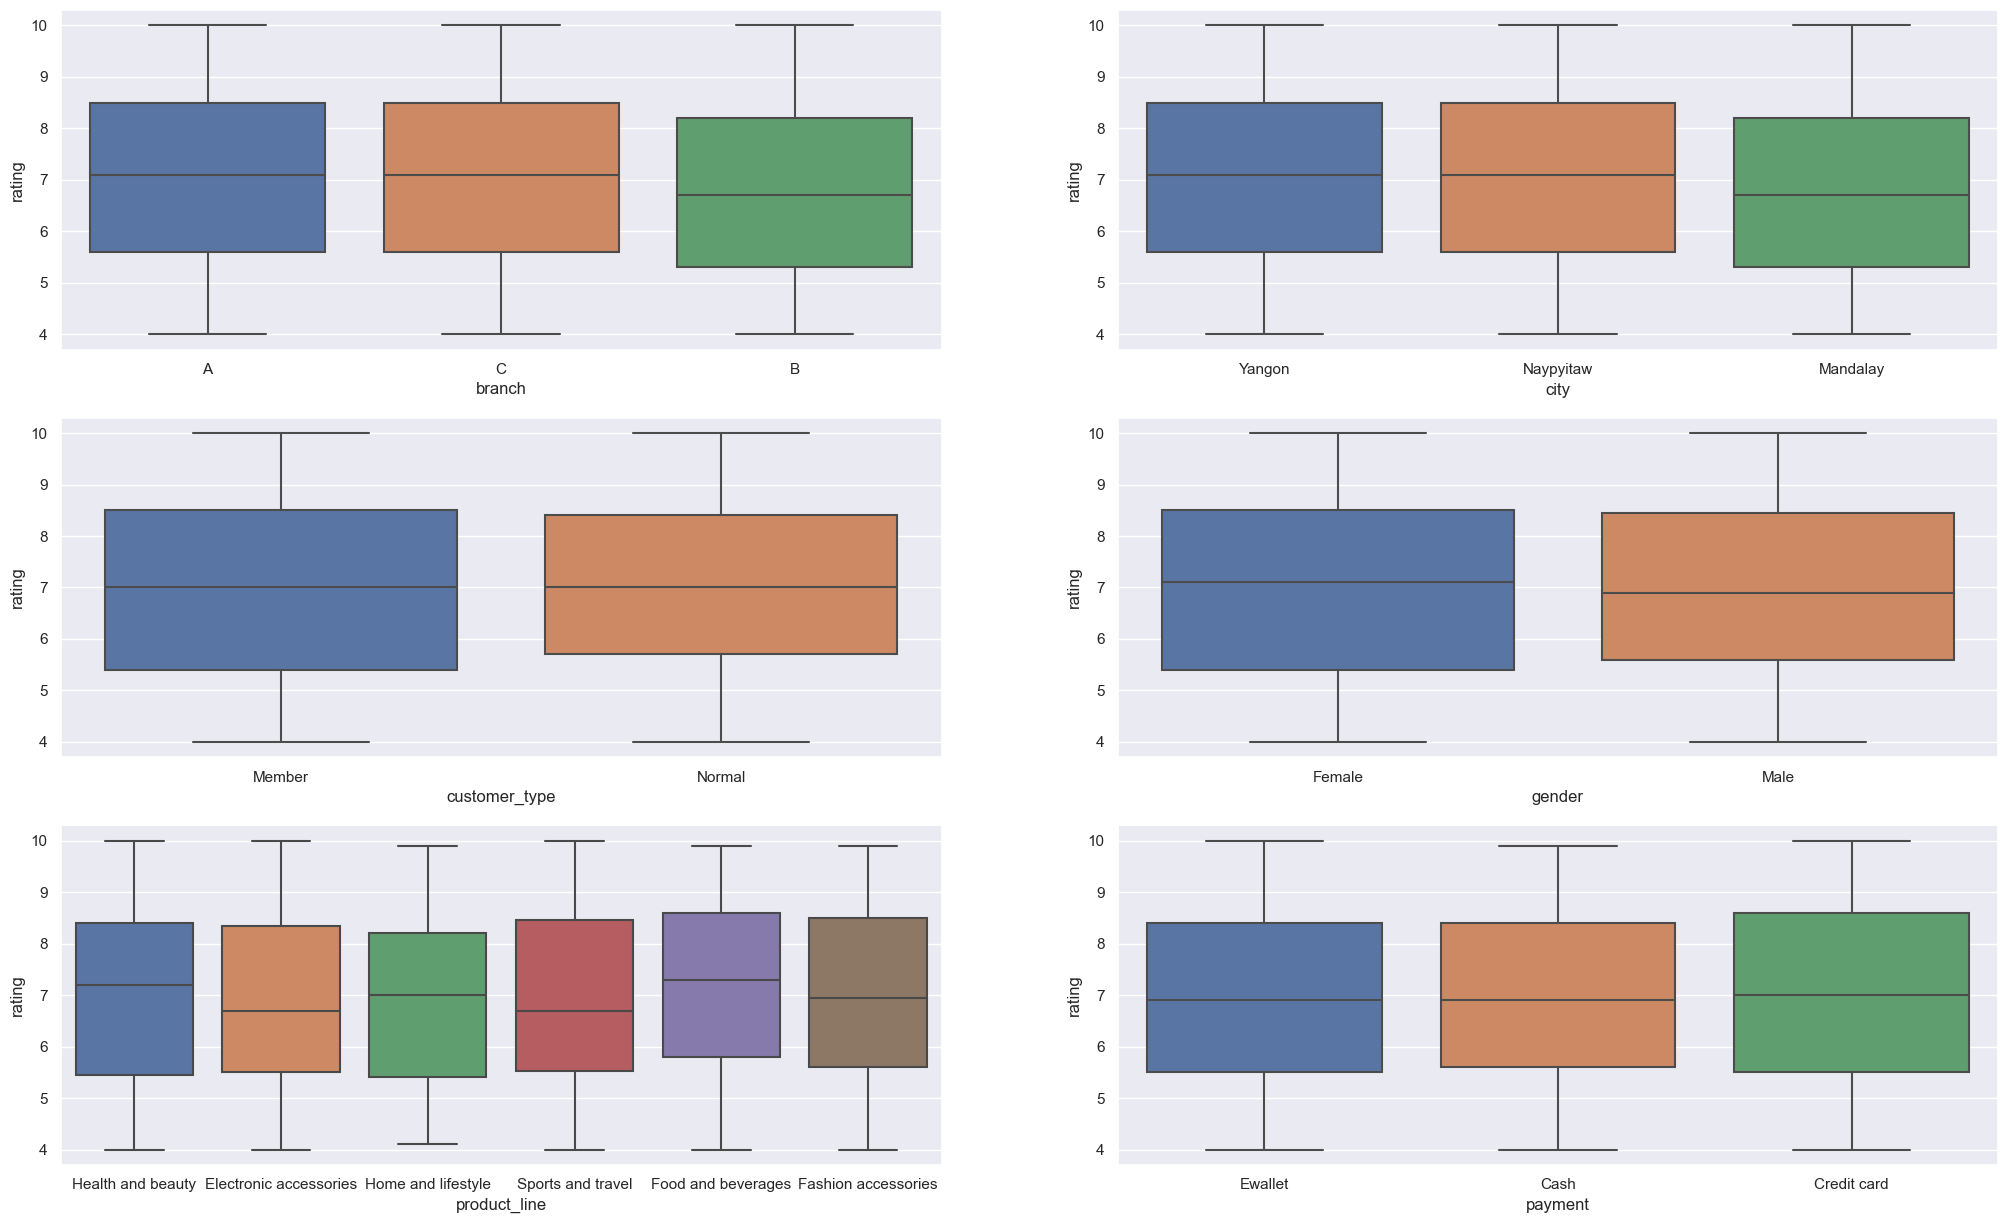

In [12]:
plt.rcParams['figure.figsize'] = [25,15] #configura tamanho de exibição da imagem plotada

#Boxplots
plt.subplot(3,2,1) #cria sub campos de plot (matriz 3x2) para ser possível exibir mais graficos em uma mesma janela
sns.boxplot(data = dados,x='branch', y='rating') #cria boxplot da variável 'branch' por 'rating'

plt.subplot(3,2,2) #Segundo plot da matriz de plots 3x2
sns.boxplot(data = dados,x='city', y='rating') #cria boxplot da variável 'city' por 'rating'

plt.subplot(3,2,3)#Terceiro plot da matriz de plots 3x2
sns.boxplot(data = dados,x='customer_type', y='rating')#cria boxplot da variável 'customer_type' por 'rating'

plt.subplot(3,2,4)#Quarto plot da matriz de plots 3x2
sns.boxplot(data = dados,x='gender', y='rating')#cria boxplot da variável 'gender' por 'rating'

plt.subplot(3,2,5)#Quinto plot da matriz de plots 3x2
sns.boxplot(data = dados,x='product_line', y='rating')#cria boxplot da variável 'product_line' por 'rating'

plt.subplot(3,2,6)#Sexto plot da matriz de plots 3x2
sns.boxplot(data = dados,x='payment', y='rating')#cria boxplot da variável 'payment' por 'rating'

Para cada variável, temos os níveis muito bem balanceados em relação a variável resposta não indicando haver boa explicação individual específica. O que pode ser ruim para a aprendizagem do modelo não haja boa correlação entre as variáveis explicativas com a variável resposta.

###### A análise das variáveis temporais pode ser feito semelhante à das númericas

In [13]:
# Apenas datas e horas
df = dados.copy() #objeto 'df' recebe uma cópia da base de dados 'dados'
df.time = pd.to_datetime(dados.time) #converte variável 'time' para tipo datetime64
summary_date = df[['date','time']] #objeto 'summary_date' recebe as colunas 'date' e 'time' do dataframe 'df'

#Função describe exibe algumas descritivas do dataframe passado como argumento
pd.DataFrame.describe(summary_date,datetime_is_numeric=True) #converte para dataframe

,date,time
count,1000,1000
mean,2019-02-14 00:05:45.600000,2022-11-19 15:24:41.880000
min,2019-01-01 00:00:00,2022-11-19 10:00:00
25%,2019-01-24 00:00:00,2022-11-19 12:43:00
50%,2019-02-13 00:00:00,2022-11-19 15:19:00
75%,2019-03-08 00:00:00,2022-11-19 18:15:00
max,2019-03-30 00:00:00,2022-11-19 20:59:00


Podemos ter uma noção do período do fluxo de compra da empresa em suas filiais.

Obs.: O método .describe não concatena no retorno variáveis de tipos diferentes, sendo assim necessário converter a variável time para datetime, onde agora é possível fazer a análise em conjunto com a variável date, no entanto a conversão retorna a data no formato. Como a data não foi adicionada na coluna variável time, a função retorna a data atual.

### 1.7 Distribuições


#### 1.7.1 Variável Resposta

###### Com os gráficos de densidade, podemos ver que os valores das notas de avaliação se distribuem entre 4 e 10.

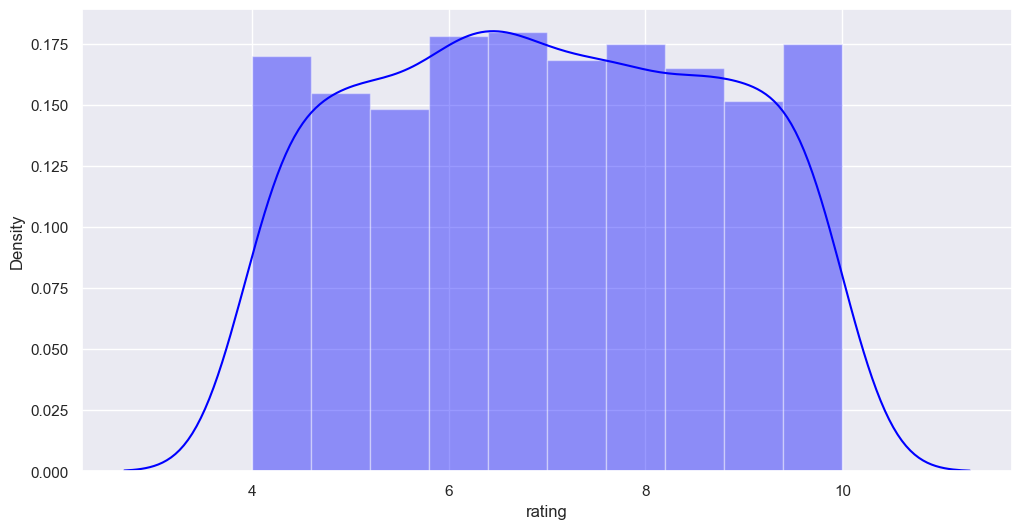

In [14]:
plt.rcParams['figure.figsize'] = [12,6] #configura tamanho de exibição do plot
sns.distplot(df['rating'], color='blue'); #exibe a densidade da variável resposta 

#### 1.7.2 Variáveis Númericas

###### Para evitar sobrescrever dados e ser necessário reexecutar todo código, é interessnate ir salvando cópias do dataset em cada seção, assim em casos de erros é reexecutar a seção.

In [15]:
df1 = df.copy() #objeto 'df1' rebebe copia do dataframe 'df'

###### Como analisado anteriormente, as variáveis se distribuem à esquerda e vão se dispersando dando um achatamento da curva, e todas tem distribuição bem semelhantes entre si, indicando que se haver explicação para variável resposta, poucas serão necessárias para o modelo.

<AxesSubplot:xlabel='gross_income', ylabel='Density'>

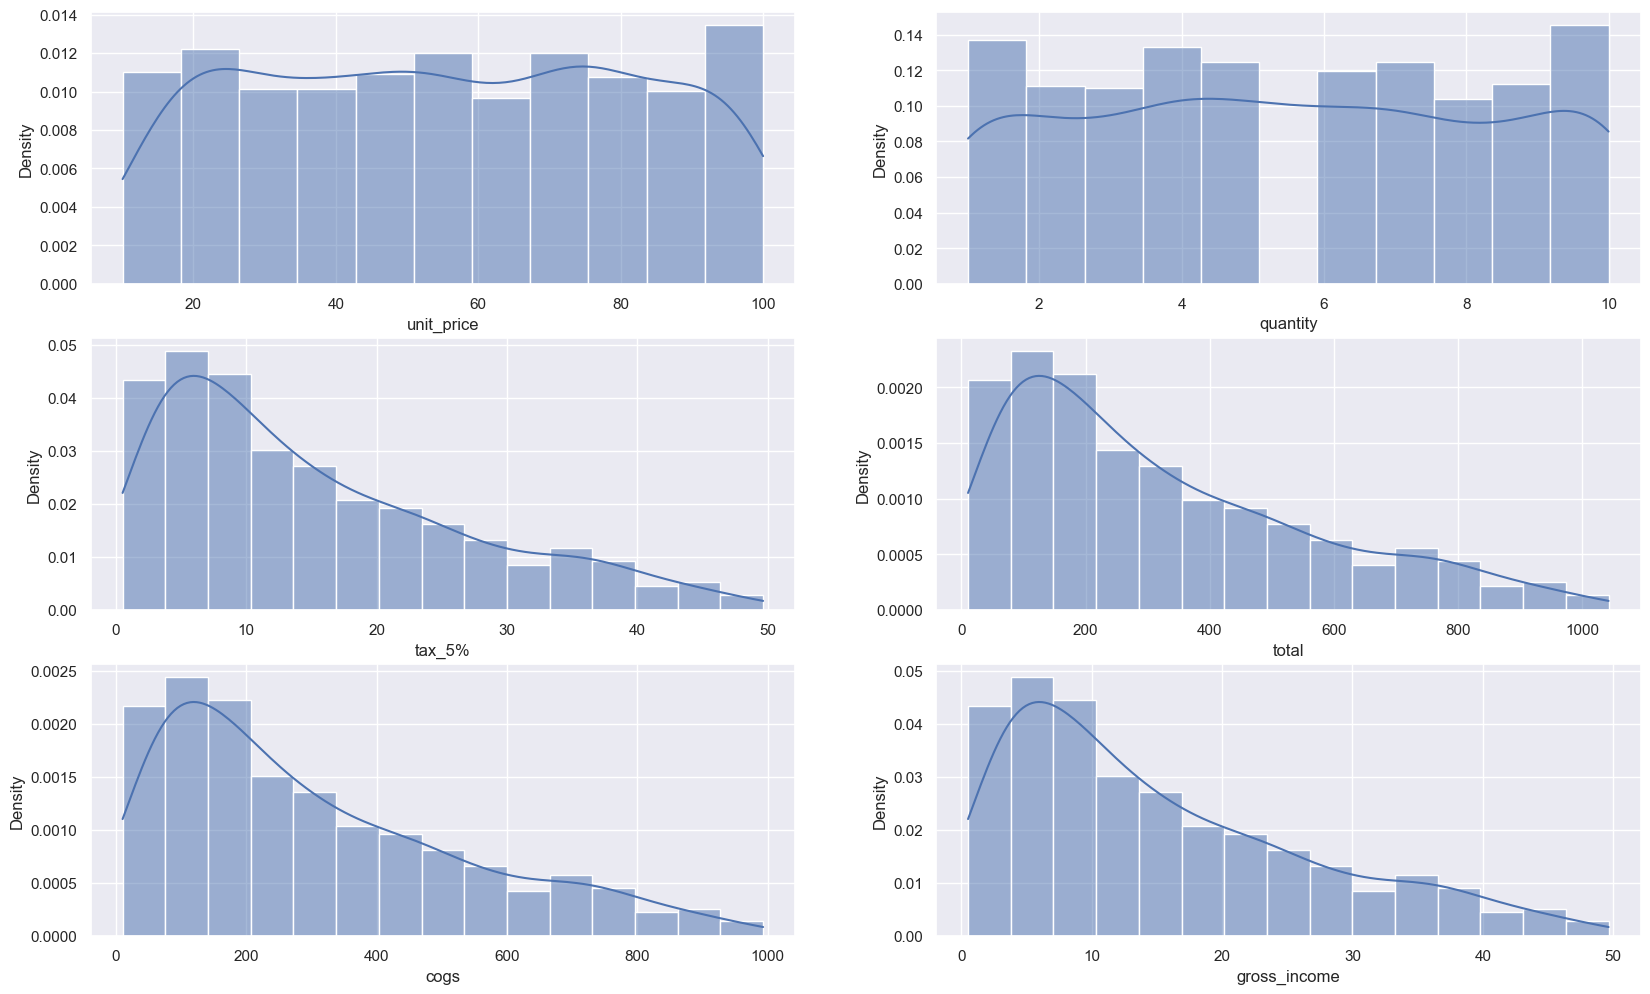

In [16]:
plt.rcParams['figure.figsize'] = [20,12] #configura tamanho de exibição do plot

plt.subplot(3,2,1) #Primeiro plot da matriz de plots 3x2
sns.histplot(df1['unit_price'],kde=True, stat='density') #plota histograma e curva de densidade para variável 'unit_price'

plt.subplot(3,2,2)#Segundo plot da matriz de plots 3x2
sns.histplot(df1['quantity'],kde=True, stat='density')#plota histograma e curva de densidade para variável 'quantity'

plt.subplot(3,2,3)#Terceiro plot da matriz de plots 3x2
sns.histplot(df1['tax_5%'],kde=True, stat='density')#plota histograma e curva de densidade para variável 'tax_5%'

plt.subplot(3,2,4) #Quarto plot da matriz de plots 3x2
sns.histplot(df1['total'],kde=True, stat='density')#plota histograma e curva de densidade para variável 'total'

plt.subplot(3,2,5)#Quinto plot da matriz de plots 3x2
sns.histplot(df1['cogs'],kde=True, stat='density')#plota histograma e curva de densidade para variável 'cogs'

plt.subplot(3,2,6)#Sexto plot da matriz de plots 3x2
sns.histplot(df1['gross_income'],kde=True, stat='density')#plota histograma e curva de densidade para variável 'gross_income'


#### 1.7.3 Variáveis Categóricas

In [17]:
plt.rcParams['figure.figsize'] = [8,6] #configura tamanho de exibição do plot

###### Podemos observar que as variáveis categóricas são bem balanceadas, não havendo necessidade de tratar o desbalanceamento dos dados.

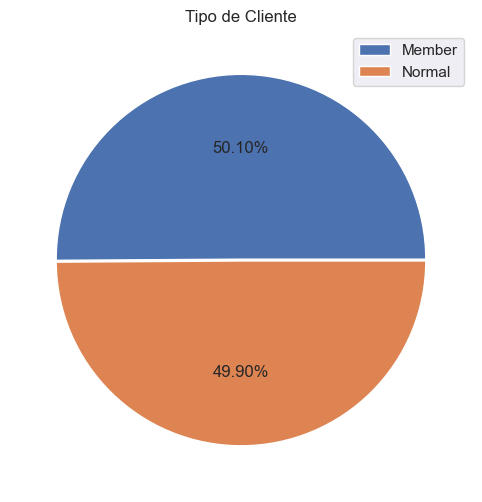

In [18]:
data = df1.groupby('customer_type').count()['invoice_id'] #objeto 'data' recebe dataframe agrupado por tipo de cliente e é aplicado a contagem de clientes para cada agrupamento
plt.pie(data.values, explode=[0.01,0.0], autopct = '%.2f%%')# gera grafico de setores 
plt.legend(data.index) #aplica legenda no gráfico de acordo com o indice dos dados
plt.title('Tipo de Cliente'); #gera o titulo do gráfico 

Text(0.5, 1.0, 'Cidades')

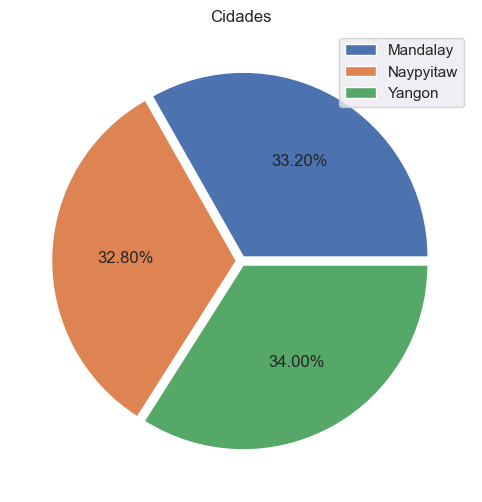

In [19]:
data = df1.groupby('city').count()['invoice_id'] #a mesa lógica do grádico anterior
plt.pie(data.values ,explode=[0.025,0.025,0.025], autopct = '%.2f%%')
plt.legend(data.index)
plt.title('Cidades')

Text(0.5, 1.0, 'Categorias')

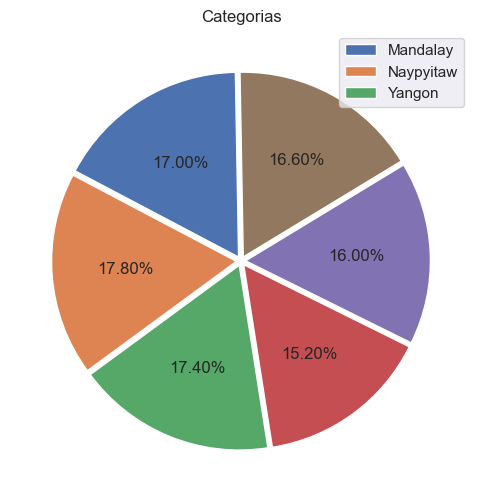

In [20]:
aux = df1.groupby('product_line').count()['invoice_id']#a mesa lógica do grádico anterior
plt.pie(aux.values ,explode=[0.025,0.025,0.025,.025,.025,.025], startangle=91 ,autopct = '%.2f%%')
plt.legend(data.index)
plt.title('Categorias')

Text(0.5, 1.0, 'Formas de Pagamento')

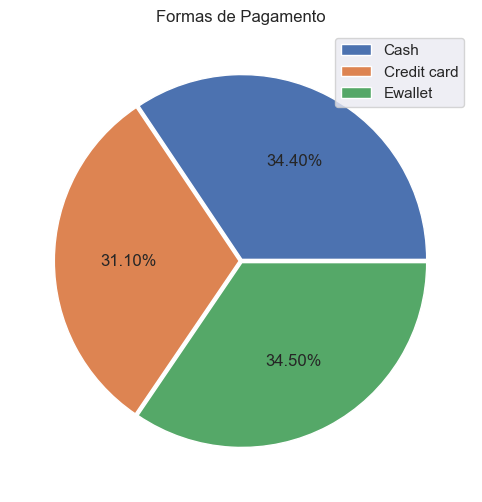

In [21]:
data = df1.groupby('payment').count()['invoice_id']#a mesa lógica do grádico anterior
plt.pie(data.values, explode=[0.01,0.01,0.01], autopct='%.2f%%');
plt.legend(data.index)
plt.title('Formas de Pagamento')

Text(0.5, 1.0, 'Sexo do Cliente')

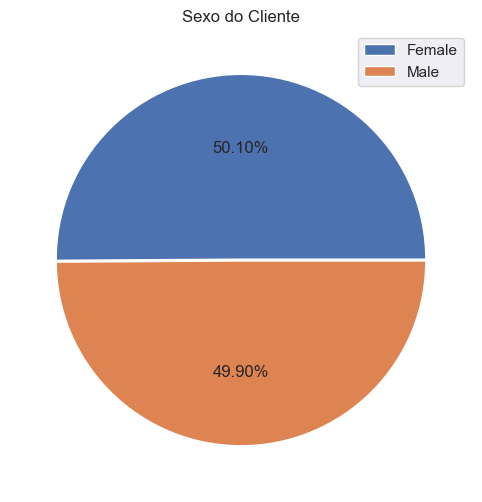

In [22]:
data = df1.groupby('gender').count()['invoice_id']#a mesa lógica do grádico anterior
plt.pie(data.values, explode=[0.01,0.0], autopct = '%.2f%%');
plt.legend(data.index)
plt.title('Sexo do Cliente')

In [23]:
#Forma alternativa de fazer a substituição dos caracteres das variáveis (alternativas: função 'map'; metodo 'rename')
df1.loc[df1['product_line'] == 'Health and beauty',['product_line']] = 'H_B'
df1.loc[df1['product_line'] == 'Electronic accessories',['product_line']] = 'E_A'
df1.loc[df1['product_line'] == 'Home and lifestyle',['product_line']] = 'H_L'
df1.loc[df1['product_line'] == 'Sports and travel',['product_line']] = 'S_T'
df1.loc[df1['product_line'] == 'Food and beverages',['product_line']] = 'F_B'
df1.loc[df1['product_line'] == 'Fashion accessories',['product_line']] = 'F_A'

df1.loc[df1['payment'] == 'Credit card',['payment']] = 'Credit_card'


###### Uma outra visualização possível é ver a distribuição em relação as valores da variável respostas. E de novo podemos afirmar o já dito sobre a semelhança do grau de explicação entre as variáveis .

<AxesSubplot:xlabel='rating', ylabel='Density'>

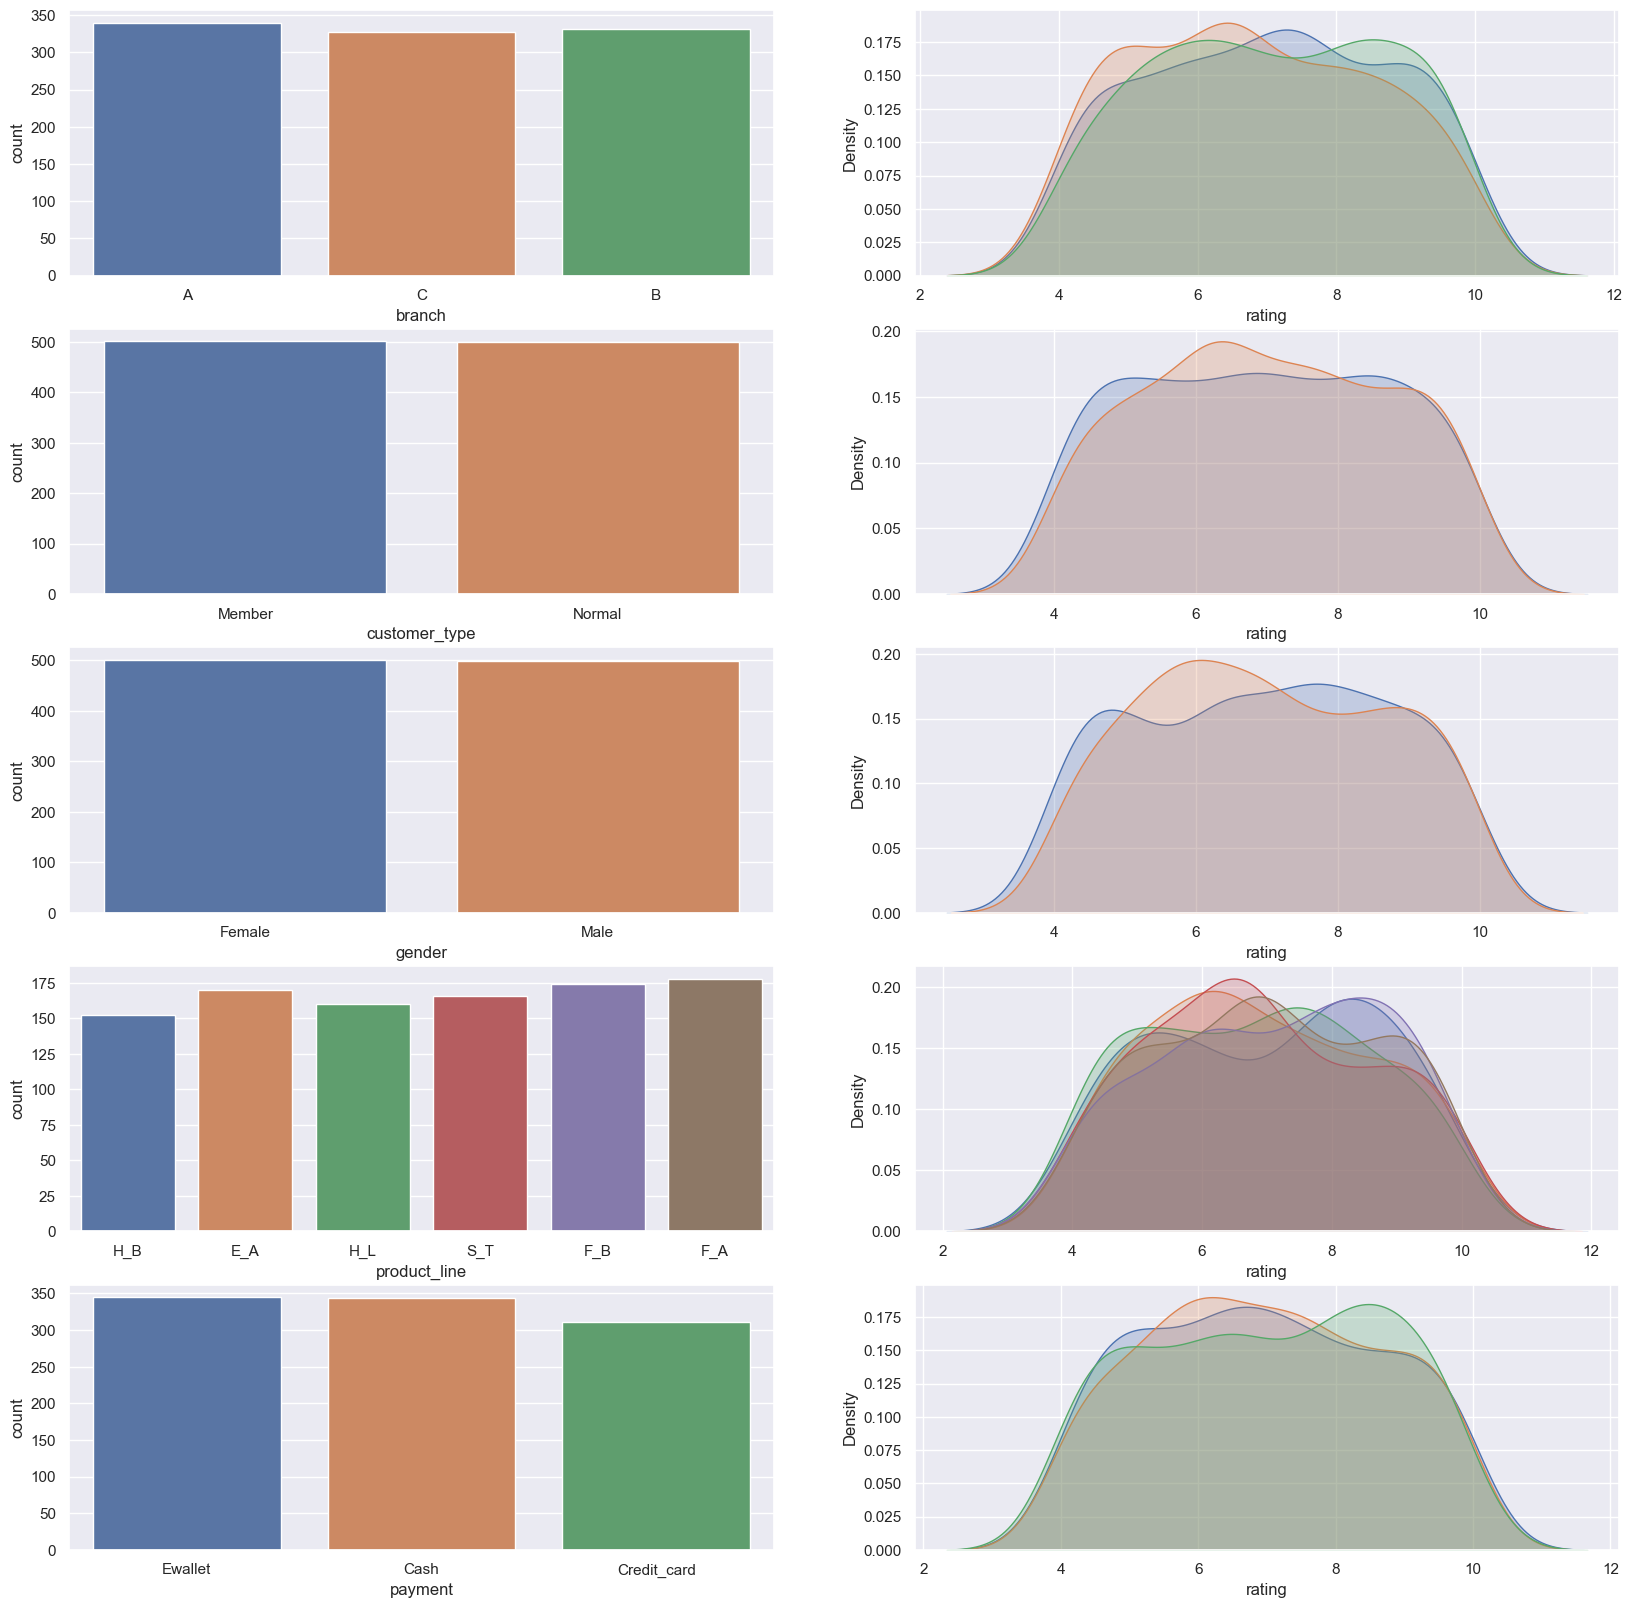

In [24]:
plt.rcParams['figure.figsize'] = [20,20] #configura o tamanho de exibição do plot

# Filial
plt.subplot(5,2,1) #primeiro plot da matriz de plots 5x2
sns.countplot(df1['branch']) #Gera grafico de frequencia para variável que representa a Filial

plt.subplot(5,2,2) #segundo plot da matriz de plots 5x2
sns.kdeplot( df1[df1['branch'] == 'A']['rating'], label='A', shade=True ) #gera curva de densidade para os níveis da variável em relação à resposta
sns.kdeplot( df1[df1['branch'] == 'B']['rating'], label='B', shade=True )
sns.kdeplot( df1[df1['branch'] == 'C']['rating'], label='C', shade=True )

# Tipo de cliente
plt.subplot(5,2,3)
sns.countplot(df1['customer_type'])#Gera grafico de frequencia para variável que representa o tipo de cliente

plt.subplot(5,2,4)
sns.kdeplot( df1[df1['customer_type']  == 'Member']['rating'], label='Member', shade=True )#gera curva de densidade para os níveis da variável em relação à resposta
sns.kdeplot( df1[df1['customer_type']  == 'Normal']['rating'], label='Normal', shade=True )


# Gênero
plt.subplot( 5, 2, 5 )
sns.countplot( df1['gender'] )#Gera grafico de frequencia para variável que representa gênero do cliente

plt.subplot( 5, 2, 6 )
sns.kdeplot( df1[df1['gender'] == 'Female']['rating'], label='Female',shade=True )#gera curva de densidade para os níveis da variável em relação à resposta
sns.kdeplot( df1[df1['gender'] == 'Male']['rating'], label='Male',shade=True )

# Categoria do produto
plt.subplot( 5, 2, 7 )
sns.countplot( df1['product_line'] )#Gera grafico de frequencia para variável que representa a categoria dos produtos

plt.subplot( 5, 2, 8 )
sns.kdeplot( df1[df1['product_line'] == 'H_B']['rating'], label='H_B',shade=True )#gera curva de densidade para os níveis da variável em relação à resposta
sns.kdeplot( df1[df1['product_line'] == 'E_A']['rating'], label='E_A',shade=True )
sns.kdeplot( df1[df1['product_line'] == 'H_L']['rating'], label='H_L',shade=True )
sns.kdeplot( df1[df1['product_line'] == 'S_T']['rating'], label='S_T',shade=True )
sns.kdeplot( df1[df1['product_line'] == 'F_B']['rating'], label='F_B',shade=True )
sns.kdeplot( df1[df1['product_line'] == 'F_A']['rating'], label='F_A',shade=True )

# Pagamento
plt.subplot( 5, 2, 9)
sns.countplot( df1['payment'] )#Gera grafico de frequencia para variável que representa a forma de pagamento utilizada pelo cliente

plt.subplot( 5, 2, 10)
sns.kdeplot( df1[df1['payment'] == 'Ewallet']['rating'], label='Ewallet',shade=True )#gera curva de densidade para os níveis da variável em relação à resposta
sns.kdeplot( df1[df1['payment'] == 'Cash']['rating'], label='Cash',shade=True )
sns.kdeplot( df1[df1['payment'] == 'Credit_card']['rating'], label='Credit_card',shade=True )




### 1.8 Correlações

###### Na matriz de correlações de Pearson, podemos observar que a variável resposta não apresenta correlação com as demais variáveis, indicando haver uma certa aleatoriedade na nota de avaliação dos cliente quando utilizamos as variáveis fornecidas para explicar tal fenômeno. Esse é um indicativo de que os modelos terão dificuldade em associar padrões para o nosso alvo. Por outro lado, as demais variáveis apresentam forte correlação entre si.

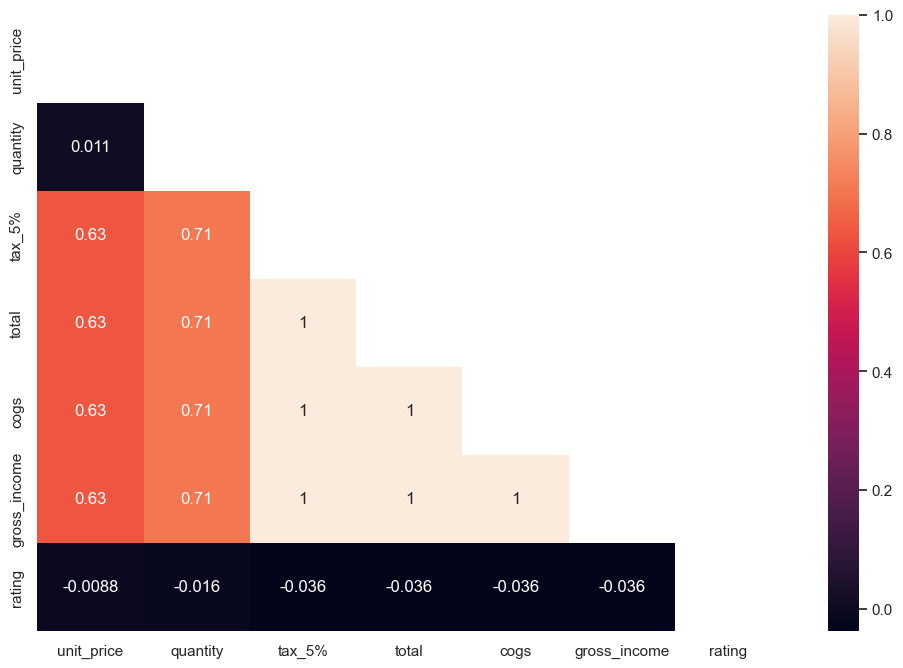

In [25]:
plt.rcParams['figure.figsize'] = [12,8] #configura o tamanho de exibição do plot
corr = numerical.drop('gross_margin_percentage',axis=1).corr(method='pearson') #corr recebe os valores da correlação de pearson para as variáveis numéricas exceto a gross_margin_percentage por ser constante
matrix = np.triu(corr) #matrix recebe a forma matricial dos valores contidos em corr (matriz triangular)

with sns.axes_style("white"): #inicia o plot com tela de fundo branco
    sns.heatmap(corr, annot=True, mask=matrix); #é criado o plor da matriz de correlações 

###### Com os plots pareados podemos observar os padrões randomicos da variável resposta com as demais.

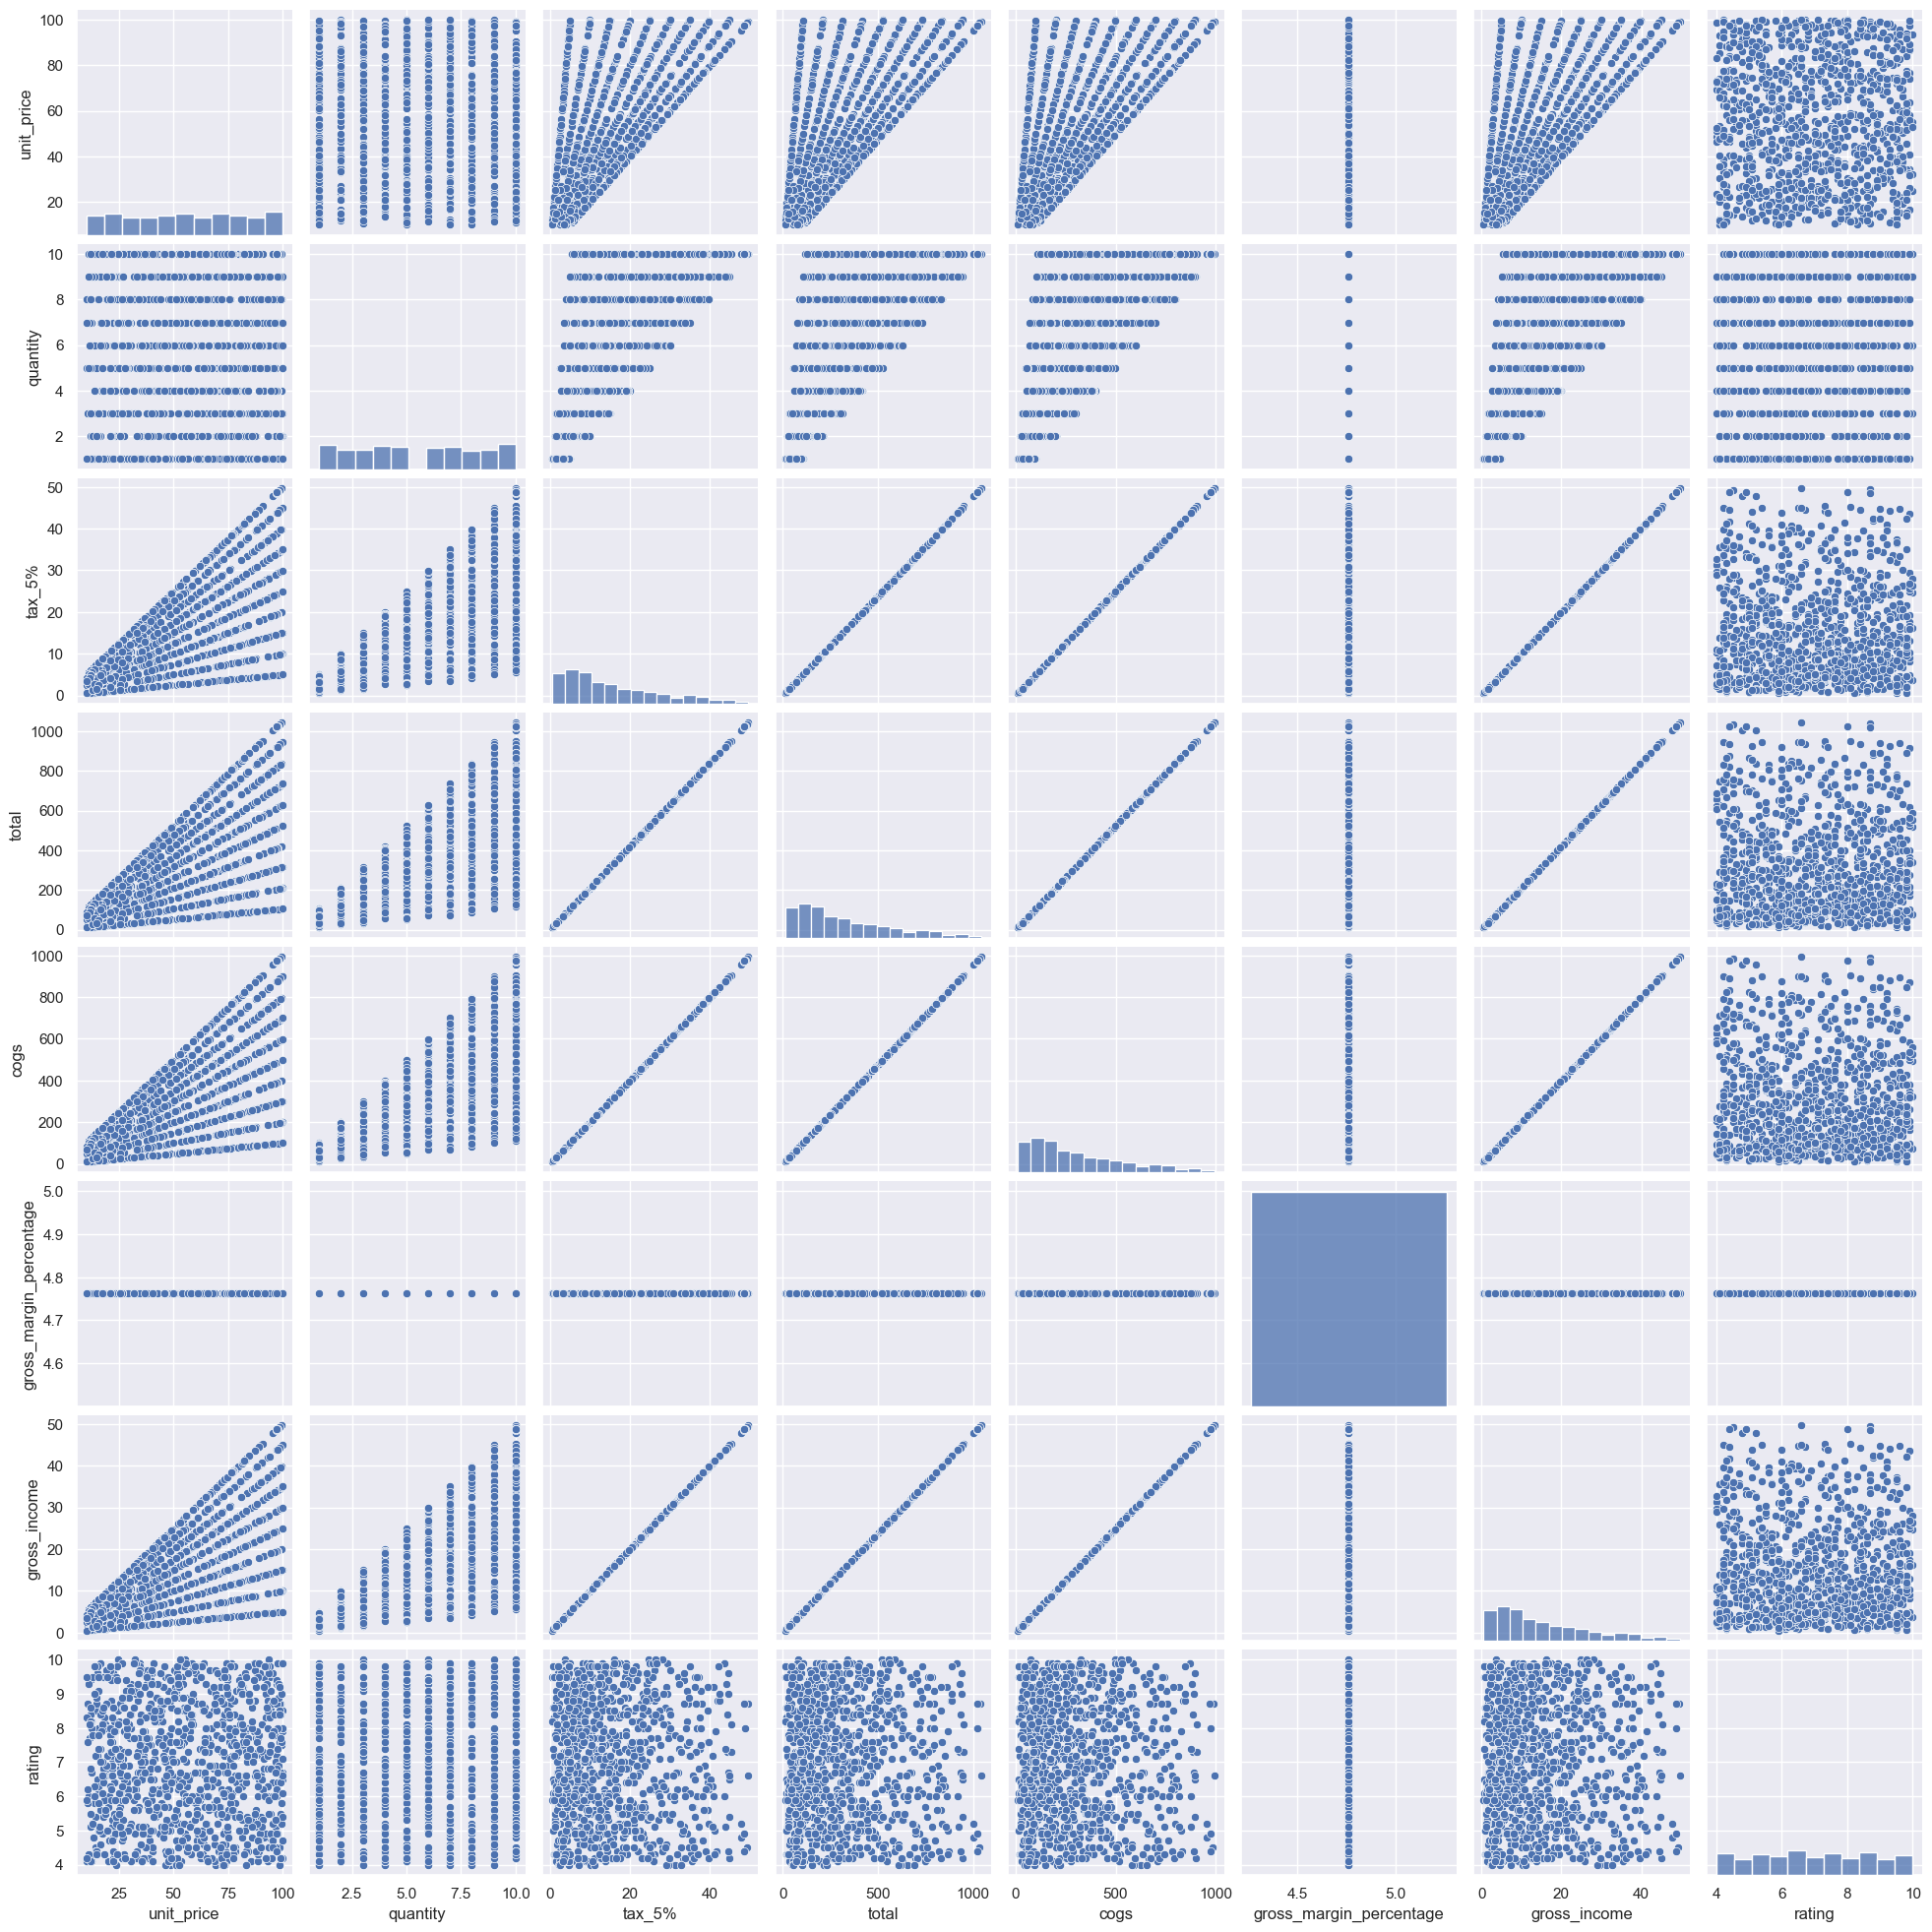

In [26]:
sns.pairplot(dados);

É fácil afirmar que de todas as variáveis, a variável rating será a mais complexa para os algoritmos. Sendo as outras muito bem explicadas pelas demais (exceto quantity vs unit price )

###### Para avaliarmos a correlação entre as variáveis categóricas, é utilizado  o V de Cramer onde obtivemos como resultados correlações muito fracas entre as variáveis.

<AxesSubplot:>

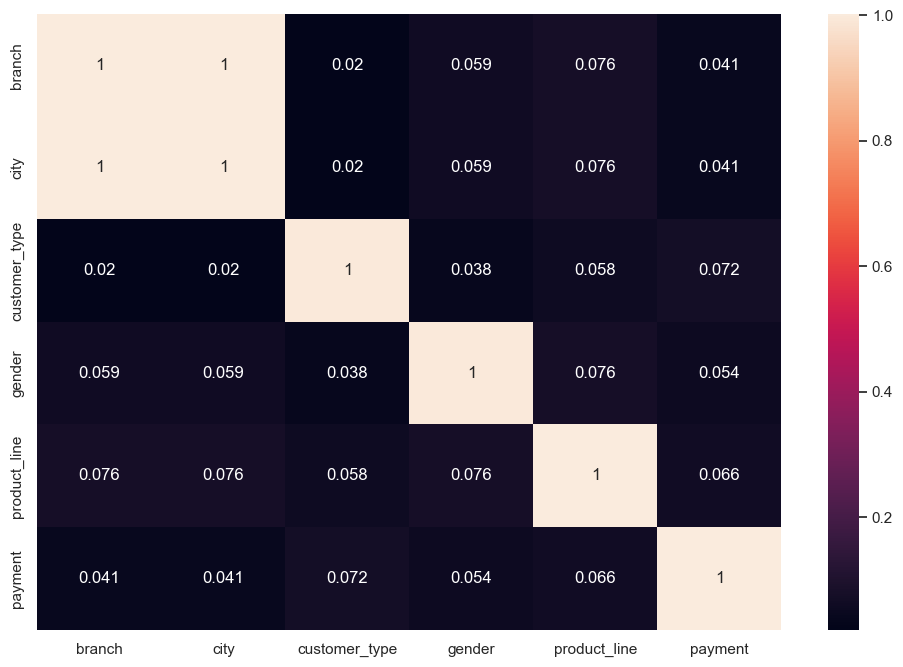

In [27]:
a = categorical
# Calculate cramer V
a1 = cramer_v( a['branch'], a['branch'] ) #a função cramer v criada na seção 0.1 recebe todas combinações das variáveis categóricas
a2 = cramer_v( a['branch'], a['city'] )
a3 = cramer_v( a['branch'], a['customer_type'] )
a4 = cramer_v( a['branch'], a['gender'] )
a5 = cramer_v( a['branch'], a['product_line'] )
a6 = cramer_v( a['branch'], a['payment'] )

a7 = cramer_v( a['city'], a['branch'] )
a8 = cramer_v( a['city'], a['city'] )
a9 = cramer_v( a['city'], a['customer_type'] )
a10 = cramer_v( a['city'], a['gender'] )
a11 = cramer_v( a['city'], a['product_line'] )
a12 = cramer_v( a['city'], a['payment'] )

a13 = cramer_v( a['customer_type'], a['branch'] )
a14 = cramer_v( a['customer_type'], a['city'] )
a15 = cramer_v( a['customer_type'], a['customer_type'] )
a16 = cramer_v( a['customer_type'], a['gender'] )
a17 = cramer_v( a['customer_type'], a['product_line'] )
a18 = cramer_v( a['customer_type'], a['payment'] )

a19 = cramer_v( a['gender'], a['branch'] )
a20 = cramer_v( a['gender'], a['city'] )
a21 = cramer_v( a['gender'], a['customer_type'] )
a22 = cramer_v( a['gender'], a['gender'] )
a23 = cramer_v( a['gender'], a['product_line'] )
a24 = cramer_v( a['gender'], a['payment'] )

a25 = cramer_v( a['product_line'], a['branch'] )
a26 = cramer_v( a['product_line'], a['city'] )
a27 = cramer_v( a['product_line'], a['customer_type'] )
a28 = cramer_v( a['product_line'], a['gender'] )
a29 = cramer_v( a['product_line'], a['product_line'] )
a30 = cramer_v( a['product_line'], a['payment'] )

a31 = cramer_v( a['payment'], a['branch'] )
a32 = cramer_v( a['payment'], a['city'] )
a33 = cramer_v( a['payment'], a['customer_type'] )
a34 = cramer_v( a['payment'], a['gender'] )
a35 = cramer_v( a['payment'], a['product_line'] )
a36 = cramer_v( a['payment'], a['payment'] )

# Final dataset
d = pd.DataFrame( {'branch': [a1,a2, a3,a4,a5,a6], 'city':[a7,a8,a9,a10,a11,a12],'customer_type': [a13,a14,a15,a16,a17,a18],  #Converte o dicionario em dataframe
                   'gender': [a19,a20,a21,a22,a23,a24],'product_line':[a25,a26,a27,a28,a29,a30],'payment':[a31,a32,a33,a34,a35,a36]}) #as colunas são as variáveis
                                                                                                                                # as linhas são os valores do v de cramer 
d = d.set_index( d.columns ) #considera as colunas como indices (para gerar o eixo y no plot)
sns.heatmap( d, annot=True ) #é plotado a matriz de correlação de cramer

## 2.0 Feature Engineering 

In [28]:
df2 = df1.copy() #df2 recebe uma cópia do dataframe df1

###### A criação de novas features são importantissimas para obtermos outros subsidios auxiliares para os algoritmos da modelagem. No entanto vimos que as variáveis apresentadas possuem fortes semelhanças entre si assim como score de correlação, nesse sentido fico dificultosa a extração de novas características que conseigam explicar o que as já existentes não explicam. Em outras palavras, as novas features derivadas das existentes teriam correlação forte entre si e continuaria fraca para nossa resposta e para as demais. Em situações reais seria válido a extração de features através de API's ou a requisição diretamente do cliente ou da equipe responsável por tal na empresa. Das etapas para melhoria do modelo, não é perigoso afirmar que a feature engineering é a que mais tem potencial de ajuda para a aprendizagem dos modelos. 



In [29]:
df2['gastos'] = df2['total'].apply(lambda x: 'alto' if x >= df2.total.mean() else 'baixo') #aplica um filtro onde todos valores maiores ou iguais  à média de 'total' 
                                                                #são rotulados como 'alto' e 'baixo' caso contrario. Esses valores compoem a nova coluna chamada 'gastos'
    
df2['humor'] = df2['date'].apply(lambda x: 'bom' if x.day <= 10 else ('normal' if (10 < x.day <= 20) else 'ruim')) #a nova coluna 'humor' é criada a partir do filtro 
         #que considera os dias do mês. Se o dia for <= a 10 é rotulado 'bom', entre 10 e 20 é rotulado 'normal', caso contrario 'ruim'

# Exemplo em pandas (mais extenso) 
df2.loc[(df2['quantity'] > df2.quantity.mean()) & (df2['customer_type'] == 'Member'),['relacao']] = 'boa' #cria coluna 'relacao' onde recebe 'boa' se a quantidade 
                                                                    # comprada é maior que a média e o tipo de cliente é membro

df2.loc[(df2['quantity'] < df2.quantity.mean()) & (df2['customer_type'] == 'Normal'),['relacao']] = 'ma' #na coluna ja criada 'relacao' é passado 'ma' se a quantidade 
                                                                                    #comprada é menor que a média e o tipo de cliente é Normal
                                                                                        
df2.loc[(df2['relacao'] != 'boa') & (df2['relacao'] != 'ma') ,['relacao']] = 'regular' #Na coluna 'relacao' é passado 'regular' os valores forem diferetes de 'boa' ou 'ma'

# Dias
df2['day'] = df2['date'].dt.day #Nova coluna 'day' recebe os dias extraidos da coluna 'date'

# Meses 
df2['month'] = df2['date'].dt.month #Nova coluna 'month' recebe os meses extraidos da coluna 'date'

# Semanas do ano
df2['week_of_year'] = df2['date'].dt.weekofyear #Nova coluna 'week_of_year' recebe as semanas do ano extraidas da coluna 'date'

# Horas
df2['hour'] = df2['time'].dt.hour #Nova coluna 'hour' recebe as horas extraidas da coluna 'time'


Como novas variáveis, temos:
- **gastos**: 'alto' para clientes que tiveram gasto total maior que a médias dos demais, 'baixo' caso contrário

- **humor**: 'bom' para os 10 primeiros dias do mês, 'normal' para os dias de 11 à 20 do mês e ruim para os dias do mês acima de 20. Busca trazer sensação em relação à despesas dado situação financeira no decorrer do mês. Considerando a suposição de ter mais dinheiro disponível no início do mês e ir decrementando com o passar dos dias

- **relacao**: 'boa' se o cliente é membro de serviços oferecidos pela empresa e e comprou mais que a média dos demais clientes, 'ma' se o cliente não é membro e comprou menos que a média dos demais clientes. 'regular' caso não seja nenhum do dois perfis.

- **day**: Dia do mês 
- **month**: Mês do ano
- **week_of_year**: Semana do ano
- **hour**: Hora do dia (transformação da coluna time para melhor manuseamento)

In [30]:
a = df2
a1 = cramer_v( a['relacao'], a['branch'] )
a2 = cramer_v( a['relacao'], a['city'] )
a3 = cramer_v( a['relacao'], a['customer_type'] )
a4 = cramer_v( a['relacao'], a['gender'] )
a5 = cramer_v( a['relacao'], a['product_line'] )
a6 = cramer_v( a['relacao'], a['payment'] )
a6 = cramer_v( a['relacao'], a['relacao'] )
a8 = cramer_v( a['relacao'], a['gastos'] )
a9 = cramer_v( a['relacao'], a['humor'] )

a10 = cramer_v( a['gastos'], a['branch'] )
a11 = cramer_v( a['gastos'], a['city'] )
a12 = cramer_v( a['gastos'], a['customer_type'] )
a13 = cramer_v( a['gastos'], a['gender'] )
a14 = cramer_v( a['gastos'], a['product_line'] )
a15 = cramer_v( a['gastos'], a['payment'] )
a16= cramer_v( a['gastos'], a['relacao'] )
a17 = cramer_v( a['gastos'], a['gastos'] )
a18 = cramer_v( a['gastos'], a['humor'] )

a19 = cramer_v( a['humor'], a['branch'] )
a20 = cramer_v( a['humor'], a['city'] )
a21 = cramer_v( a['humor'], a['customer_type'] )
a22 = cramer_v( a['humor'], a['gender'] )
a23 = cramer_v( a['humor'], a['product_line'] )
a24 = cramer_v( a['humor'], a['payment'] )
a25 = cramer_v( a['humor'], a['relacao'] )
a26 = cramer_v( a['humor'], a['gastos'] )
a27 = cramer_v( a['humor'], a['humor'] )

d = pd.DataFrame( {'relacao': [a1,a2, a3,a4,a5,a6,a7,a8,a9], 'gastos':[a10,a11,a12,a13,a14,a15,a16,a17,a18],'humor': [a19,a20,a21,a22,a23,a24,a25,a26,a27],
                   'index':['branch','city','customer_type','gender','product_line','payment','relacao','gastos','humor']}) 
d = d.set_index('index')
d

,relacao,gastos,humor
index,,,
branch,0.067934,0.029729,0.018303
city,0.067934,0.029729,0.018303
customer_type,0.706786,0.004356,0.042612
gender,0.063032,0.053395,0.063044
product_line,0.065343,0.046916,0.057070
payment,1.001002,0.013502,0.043510
relacao,1.001002,0.410547,0.070254
gastos,0.410547,0.998423,0.020413
humor,0.070254,0.020413,1.001002


Como era esperado, as novas features tem forte correlação entre as que a deram origem e permanece fraca para as demais.

## 3.0 Filtragem de Variáveis

In [31]:
df3 = df2.copy() #df3 recebe uma cópia do dataframe 'df2'

###### Nessa etapa de filtragem, é importante deixarmos no dataset apenas as variáveis e observações que façam sentido para o estudo. A variável gross_margin_percentage é uma constante, logo não agrega informação. São consideradas as observações com notas de avaliação entre 0 e 10 e as variáveis de tempo não são mais necessárias levando em conta que já foram extraídas as informações das mesmas na feature engineering. Assim como a variável branch não fornece mais informação que a city, dado que ambas são equivalentes, poderiamos escolhar deixar qualquer uma das duas.

In [32]:
df3.gross_margin_percentage.unique() #É exibido os valores unicos da coluna 'gross_margin_percentage'

array([4.76190476])

In [33]:
## Filtragem das Linhas
#Apenas Avaliações Válidas
df3 = df3[(df3['rating'] >= 0) & (df3['rating'] <= 10)] # dataframe df3 é filtrado por valores onde a coluna rate está entre 0 e 10

## Filtragem das Colunas
#Removendo Variáveis Desnecessárias
cols_drop = ['invoice_id','branch','gross_margin_percentage','date','time'] # cols_drop recebe uma lista com caracteres representando os nomes das colunas de interesse
df3 = df3.drop(cols_drop, axis=1 ) #as colunas de interesse são removidas do dataframe df3

## 4.0 Preparação dos Dados

In [34]:
df4 = df3.copy() #df4 recebe uma cópia do dataframe df3

### 4.1 Rescaling

###### Para que o aprendizado dos modelos não tenha influência por certas variáveis possuírem valores muito maiores que outras, faremos a padronização dessa escala de valores.

In [35]:
summary(df4) #é aplicada a função summary criada na seção 0.1

,Min,Max,Range,Median,Mean,Standard Deviation,Skewness,Kurtosis
unit_price,10.0800,99.96,89.8800,55.230,55.672130,26.481378,0.007077,-1.218591
quantity,1.0000,10.00,9.0000,5.000,5.510000,2.921969,0.012941,-1.215547
tax_5%,0.5085,49.65,49.1415,12.088,15.379369,11.702970,0.892570,-0.081885
total,10.6785,1042.65,1031.9715,253.848,322.966749,245.762362,0.892570,-0.081885
cogs,10.1700,993.00,982.8300,241.760,307.587380,234.059392,0.892570,-0.081885
gross_income,0.5085,49.65,49.1415,12.088,15.379369,11.702970,0.892570,-0.081885
rating,4.0000,10.00,6.0000,7.000,6.972700,1.717721,0.009010,-1.151587
day,1.0000,31.00,30.0000,15.000,15.256000,8.689215,0.049749,-1.226543
month,1.0000,3.00,2.0000,2.000,1.993000,0.834836,0.013144,-1.566889
week_of_year,1.0000,13.00,12.0000,7.000,6.996000,3.594716,0.030941,-1.191475


In [36]:
mms = MinMaxScaler() #mms recebe o módulo de scaling MinMaxScaler

#unit_price
df4['unit_price'] = mms.fit_transform( df4[['unit_price']].values ) #os valores da coluna 'unit_price' são passados para o scaler ser 'fitado' e é aplicada a transformação

#tax_5%
df4['tax_5%'] = mms.fit_transform( df4[['tax_5%']].values ) #os valores da coluna 'tax_5%' são passados para o scaler ser 'fitado' e é aplicada a transformação

#total
df4['total'] = mms.fit_transform( df4[['total']].values ) #os valores da coluna 'total' são passados para o scaler ser 'fitado' e é aplicada a transformação

#cogs
df4['cogs'] = mms.fit_transform( df4[['cogs']].values ) #os valores da coluna 'cogs' são passados para o scaler ser 'fitado' e é aplicada a transformação

#gross_income
df4['gross_income'] = mms.fit_transform( df4[['gross_income']].values ) #os valores da coluna 'gross_income' são passados para o scaler ser 'fitado' e é aplicada a transformação


Observando a dispersão dos valores das variáveis através do sumário, foi considerada para padronização de MinMax scaler aquelas que possuem maiores valores de desvio em relação às medidas de tendência central.

### 4.2 Transformação

###### Filtrando as variáveis categóricas podemos ter uma melhor noção dos tipos de transformação que utilizaremos

In [37]:
df4.select_dtypes(include='object').head() #do dataframe df4 são selecionados apenas as colunas do tipo 'object' e é aplicado a função que retorno as 6 primeiras linhas

,city,customer_type,gender,product_line,payment,gastos,humor,relacao
0,Yangon,Member,Female,H_B,Ewallet,alto,bom,boa
1,Naypyitaw,Normal,Female,E_A,Cash,baixo,bom,ma
2,Yangon,Normal,Male,H_L,Credit_card,alto,bom,regular
3,Yangon,Member,Male,H_B,Ewallet,alto,ruim,boa
4,Yangon,Normal,Male,S_T,Ewallet,alto,bom,regular


#### 4.2.1 Transformação de Natureza

###### Para as variáveis que representam um ciclo (ou seja, o mês 12 está distante de do mês 5 mas muito próximo do mês 1) será utilizada a transformação de natureza baseada no círculo trigonométrico, onde capta essa ordem ciclica dos períodos

In [38]:
# month
df4['month_sin'] = df4['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) ) #nova coluna recebe valores da aplicação de uma equação para cada valor da coluna 'month' 
df4['month_cos'] = df4['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) ) #nova coluna recebe valores da aplicação de equação para cada valor da coluna 'month'

# day
df4['day_sin'] = df4['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) ) #nova coluna recebe valores da aplicação de uma equação para cada valor da coluna 'day'
df4['day_cos'] = df4['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) ) #nova coluna recebe valores da aplicação de uma equação para cada valor da coluna 'day'

# week of year
df4['week_of_year_sin'] = df4['week_of_year'].apply( lambda x: np.sin( x * ( 2* np.pi/52 ) ) )#nova coluna recebe valores da aplicação de uma equação para cada valor da coluna 'week_of_year'
df4['week_of_year_cos'] = df4['week_of_year'].apply( lambda x: np.cos( x * ( 2* np.pi/52 ) ) )#nova coluna recebe valores da aplicação de uma equação para cada valor da coluna 'week_of_year'

# week of year
df4['hour_sin'] = df4['hour'].apply( lambda x: np.sin( x * ( 2* np.pi/24 ) ) ) #nova coluna recebe valores da aplicação de uma equação para cada valor da coluna 'hour'
df4['hour_cos'] = df4['hour'].apply( lambda x: np.cos( x * ( 2* np.pi/24 ) ) ) #nova coluna recebe valores da aplicação de uma equação para cada valor da coluna 'hour'

#### 4.2.2 Encoding

###### Para as variáveis categóricas que não possuem ordem (seja ciclica ou propriamente ordinal) a transformação por dummies é suficiente.

In [39]:
# One-Hot-Enconding
df4 = pd.get_dummies(df4, columns=['city']) #os valores da variável 'city' são transformados em variáveis dummy
df4 = pd.get_dummies(df4, columns=['customer_type'])  #os valores da variável 'customer_type' são transformados em variáveis dummy
df4 = pd.get_dummies(df4, columns=['gender']) #os valores da variável 'gender' são transformados em variáveis dummy
df4 = pd.get_dummies(df4, columns=['product_line']) #os valores da variável 'product_line' são transformados em variáveis dummy
df4 = pd.get_dummies(df4, columns=['payment']) #os valores da variável 'payment' são transformados em variáveis dummy

###### Para as que possuem ordem de grandeza podemos dar o encoding através da ordem númerica

In [40]:
# Ordinal Encoding  (Pode ser feito com a função LabelEncoding do módulo sklearn.metrics)
gastos_dict = {'alto': 2, 'baixo': 1} #gastos_dict recebe um dicionário 
df4['gastos'] = df4['gastos'].map( gastos_dict ) #os caracteres das informações da coluna 'gastos' são substituídos pelo valor do dicionário 'gastos_dict' 
                                                #onde a chave coincide com o valor da coluna

humor_dict = {'bom': 3,'normal':2, 'ruim': 1} #humor_dict recebe um dicionário 
df4['humor'] = df4['humor'].map( humor_dict ) #os caracteres das informações da coluna 'humor' são substituídos pelo valor do dicionário 'humor_dict' 
                                            #onde a chave coincide com o valor da coluna

relacao_dict = {'boa': 3,'regular':2, 'ma': 1} #relacao_dict recebe um dicionário 
df4['relacao'] = df4['relacao'].map( relacao_dict ) #os caracteres das informações da coluna 'relacao' são substituídos pelo valor do dicionário 'relacao_dict' 
                                                  #onde a chave coincide com o valor da coluna
    


## 5.0 Seleção de Features

###### A seleção das features tem como principal objetivo simplificar a modelagem com variáveis que apresentam maior grau de explicação para nossa variável resposta, isso afeta diretamente tanto na capacidade de aprendizado mais eficiente dos algoritmos como também na diminuição do esforço computacional.

In [41]:
df5 = df4.copy() #df5 recebe uma cópia do dataframe df4
df5.head() #exibe as primeiras 6 linhas do dataframe

,unit_price,quantity,tax_5%,total,cogs,gross_income,rating,gastos,humor,relacao,...,gender_Male,product_line_E_A,product_line_F_A,product_line_F_B,product_line_H_B,product_line_H_L,product_line_S_T,payment_Cash,payment_Credit_card,payment_Ewallet
0,0.718847,7,0.521616,0.521616,0.521616,0.521616,9.1,2,3,3,...,0,0,0,0,1,0,0,0,0,1
1,0.057855,5,0.067387,0.067387,0.067387,0.067387,9.6,1,3,1,...,0,1,0,0,0,0,0,1,0,0
2,0.403316,7,0.319628,0.319628,0.319628,0.319628,7.4,2,3,2,...,1,0,0,0,0,1,0,0,1,0
3,0.535603,8,0.463549,0.463549,0.463549,0.463549,8.4,2,1,3,...,1,0,0,0,1,0,0,0,0,1
4,0.848131,7,0.604377,0.604377,0.604377,0.604377,5.3,2,3,2,...,1,0,0,0,0,0,1,0,0,1


No decorrer das etapas realizadas, temos agora presente no dataset 38 features

### 5.1 Separando dataset em conjuntos de treinamento e teste

###### Primeiramente é importante separarmos os dados em conjunto de treino e teste para que os modelos aprendam e esse aprendizado seja validado com medidas ainda não vistas, e em ambos os conjuntos a variável resposta deve ser isolada para não viesar o aprendizado do modelo.

In [89]:
#Divide o dataframe em outros 4 dataframes, 2 para treinamento e 2 para teste (separando a variável resposta das demais)
X_train, X_test, y_train, y_test = train_test_split(df5.drop('rating',axis=1), df5.rating, test_size=0.25, shuffle = True, random_state=20)

print(f'Dimensões:\n Variáveis explicativas para treinamento {X_train.shape}.' #exibe mensagem na tela com dimensões dos dataframes criados
     +  f'\n Variável resposta para treinamento {y_train.shape}.' 
     +  f'\n Variáveis explicativas para validação {X_test.shape}.' 
     +  f'\n Variável resposta para validação {y_test.shape}.')


Dimensões:
 Variáveis explicativas para treinamento (750, 37).
 Variável resposta para treinamento (750,).
 Variáveis explicativas para validação (250, 37).
 Variável resposta para validação (250,).


Foi considerado uma aleatorização na seleção dos conjuntos e para treino temos 75% do total de observações

### 5.2 Boruta as Feature Selector

###### O método Boruta consiste, resumidamente, em duplicar o conjunto de dados criando variáveis sombras e é feita a mistura aleatoriamente dos valores de cada coluna, verificando para cada variável real se a mesma tem uma importancia maior que a variável sombra, e se tiver é contabilizado o acerto e continuamos as demais iterações. Este passo é chamado de características de sombra e tem a função de remover suas correlações com a variável resposta.

[Mais sobre o Boruta](https://medium.com/data-hackers/como-selecionar-melhores-vari%C3%A1veis-para-o-seu-modelo-com-boruta-ef7cbfb3fc35)


In [43]:
# Dados de treino e teste para o Boruta
X_train_b = X_train.values #X_train_b recebe os valores do dataframe X_train em formatdo de 'array'
y_train_b = y_train.values.ravel() #y_train_b recebe os valores do dataframe y_train em formatdo de 'array'

# Regressor Random Forest
rf = RandomForestRegressor( n_jobs=-1 ) #rf recebe o construtor do modelos random forest para regressão

# Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=20).fit(X_train_b,y_train_b) #é ajustado o processo boruta com modelo random forest


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	37
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	0
Rejected: 	37


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	0
Rejected: 	37


O método Boruta entende que as variáveis não são suficientes para explicar nossa variável resposta

### 5.3 Select K Best 

###### O método Select K Best se baseia em construir um modelo (no nosso caso é uma Regressão) e com ela são capturadas as estatisticas F, com isso são retornadas as variáveis com os K maiores scores da estatística F.

In [44]:
X_new = SelectKBest(f_regression,k=15) #X_new recebe metodo Select K Best configurado por função regressão e retornar as 15 melhores
ajuste = X_new.fit(X_train, y_train) #ajuste recebe o ajuste feito para o X_new
features = ajuste.transform(X_train) #features recebe as 15 melhores features selecionadas

In [45]:
X_train.iloc[:,ajuste.get_support(indices=True)] #exibe o dataframe com as 15 melhores selecionadas

,quantity,total,gross_income,relacao,month,week_of_year,month_sin,month_cos,week_of_year_sin,week_of_year_cos,city_Mandalay,city_Naypyitaw,product_line_F_A,product_line_H_B,product_line_H_L
826,9,0.649980,0.649980,3,1,5,0.500000,8.660254e-01,0.568065,8.229839e-01,1,0,0,1,0
964,2,0.057477,0.057477,1,1,4,0.500000,8.660254e-01,0.464723,8.854560e-01,1,0,0,0,0
439,8,0.322243,0.322243,2,2,6,0.866025,5.000000e-01,0.663123,7.485107e-01,0,1,0,0,0
614,10,0.675936,0.675936,3,2,5,0.866025,5.000000e-01,0.568065,8.229839e-01,0,0,0,0,0
696,4,0.099702,0.099702,2,1,1,0.500000,8.660254e-01,0.120537,9.927089e-01,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,6,0.204664,0.204664,3,3,11,1.000000,6.123234e-17,0.970942,2.393157e-01,0,1,0,0,0
223,1,0.002411,0.002411,2,2,8,0.866025,5.000000e-01,0.822984,5.680647e-01,0,1,1,0,0
271,2,0.032630,0.032630,2,1,1,0.500000,8.660254e-01,0.120537,9.927089e-01,0,1,0,1,0
474,5,0.317481,0.317481,2,3,13,1.000000,6.123234e-17,1.000000,6.123234e-17,0,0,0,0,0


Temos as 15 selecionadas pelo método

### 5.4 Feature Importance

###### Outra forma de selecionarmos as features é pelos score de impureza de Gini obtidos pelos modelos de árvore (pode ser escolhido por entropia caso queira)

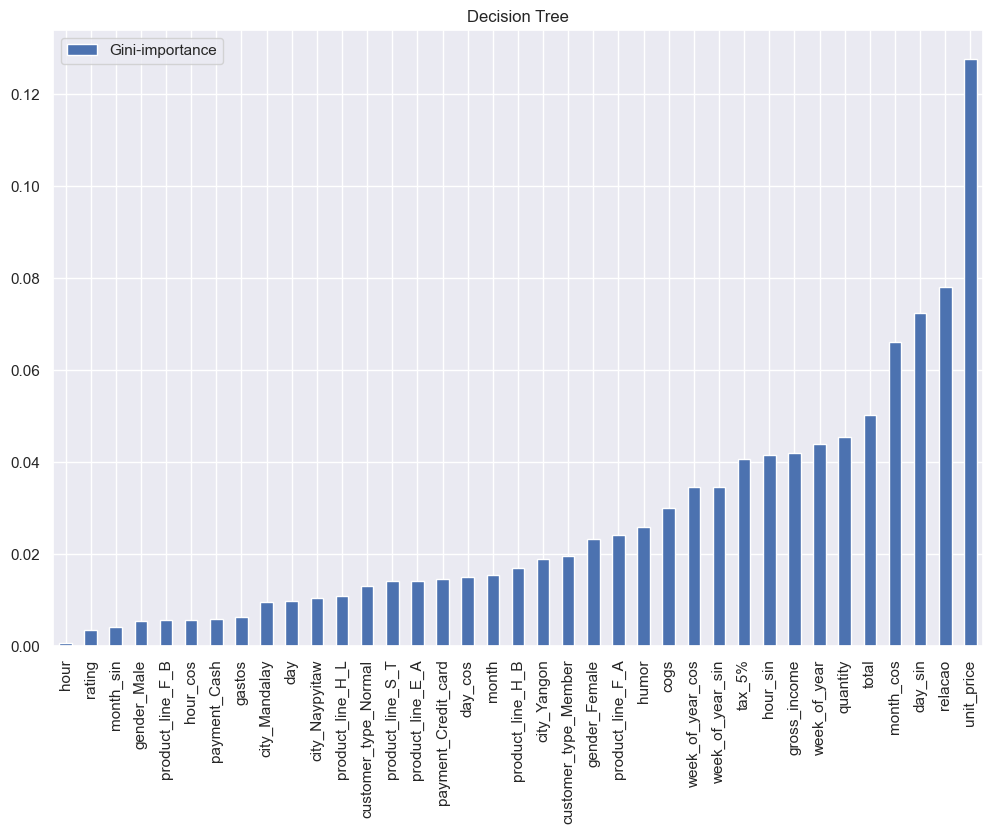

In [46]:
model = DecisionTreeRegressor() #model recebe construtor de Árvore de Decisão
model.fit(X_train, y_train) #o modelo é ajustado com os valores de treino 

importance = model.feature_importances_ #importance recebe os scores de Gini do modelo ajustado

feats = {} #feats recebe um dicionario vazio
for feature, importance in zip(df5.columns, model.feature_importances_): #feature e importance recebem os nomes e os scores das variáveis, respectivamente
    feats[feature] = importance #dicionatio feat recebe chave como nome da coluna e valor como score, para cada iteração

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'}) #converte o dicionário em dataframe
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90); #o dataframe é agrupado pelo score e plotado em barras
plt.title('Decision Tree'); #escreve titulo no plot

cols_dt = importances[importances['Gini-importance'] >= 0.02].reset_index()['index'].tolist() #cols_dt recebe as variáveis com score >= a 0.02 e converte em lista

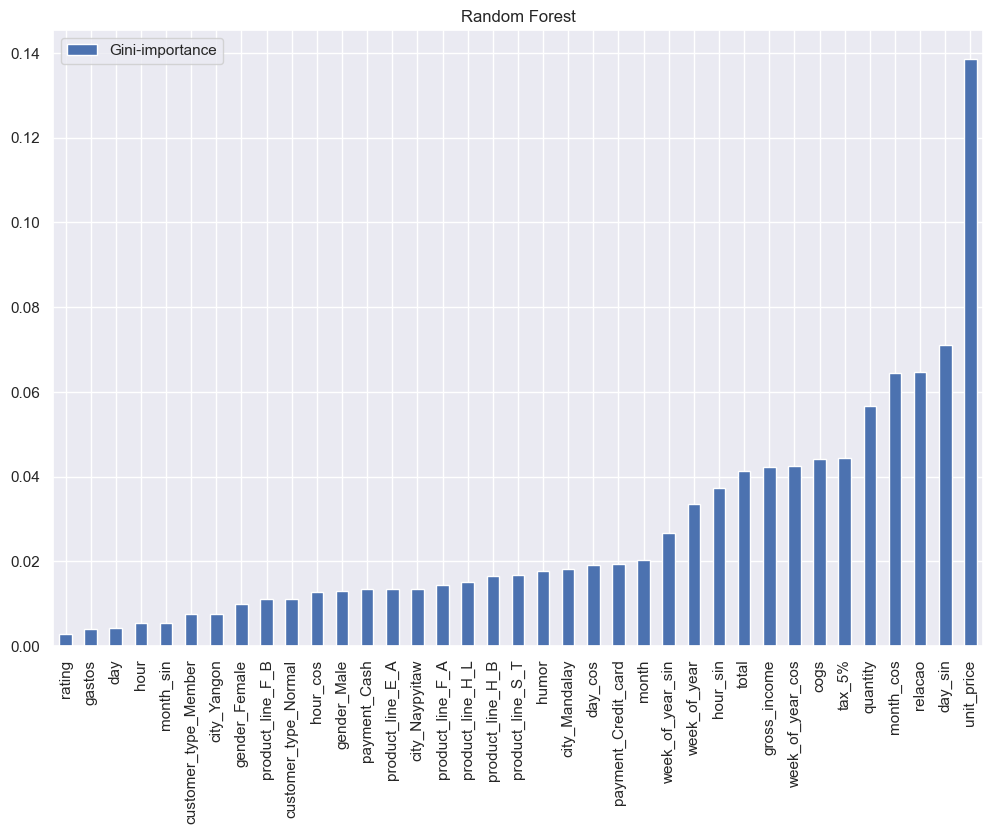

In [47]:
model = RandomForestRegressor() #model recebe construtor de Floresta Randomica
model.fit(X_train, y_train) #o modelo é ajustado com os valores de treino 

importance = model.feature_importances_ #importance recebe os scores de Gini do modelo ajustado

feats = {} #feats recebe um dicionario vazio
for feature, importance in zip(df5.columns, model.feature_importances_): #feature e importance recebem os nomes e os scores das variáveis, respectivamente
    feats[feature] = importance #dicionatio feat recebe chave como nome da coluna e valor como score, para cada iteração

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'}) #converte o dicionário em dataframe
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90) #o dataframe é agrupado pelo score e plotado em barras
plt.title('Random Forest'); #escreve titulo no plot

cols_rf = importances[importances['Gini-importance'] >= 0.02].reset_index()['index'].tolist() #cols_rf recebe as variáveis com score >= a 0.02 e converte em lista

Ambos métodos retornam scores muito baixos para as features, sendo todos esses procedimentos um forte indicativo de que os modelos não conseguiram aprender com as variáveis fornecidas.

### 5.5 Seleção Manual

###### Com base nos métodos executados, foram consideradas features selecionadas pelo maior número de métodos.

In [48]:
cols_rf #exibe os valores de cols_rf

['unit_price',
 'quantity',
 'tax_5%',
 'total',
 'cogs',
 'gross_income',
 'relacao',
 'month',
 'week_of_year',
 'month_cos',
 'day_sin',
 'week_of_year_sin',
 'week_of_year_cos',
 'hour_sin']

In [49]:
cols_selected = ['unit_price', #cols_selected recebe uma lista devalores string
                 'quantity',
                 'tax_5%',
                 'total',
                 'cogs',
                 'gross_income',
                 'relacao',
                 'month_sin',
                 'month_cos',
                 'day_sin',
                 'day_cos',
                 'week_of_year_sin',
                 'week_of_year_cos',
                 'hour_sin',
                 'hour_cos']


## 6.0 Modelagem

###### A etapa de modelagem consiste em passar os conjuntos de treino considerando as variáveis selecionadas para os modelos aprenderem. Em seguida são realizadas as predições com o conjunto de teste, com as predições e os valores reais conseguimos analisar a adequação do modelo com base em medidas de erro e pelo coeficiente de determinação que nos diz a respeito da quão bem ajustado o modelo ficou em relação aos dados. Como o conjunto de treino pode ter sido viesado por algum desbalanceamento implicito ou por uma aleatoriedade que favoreça de alguma forma, é feito a validação cruzada K folds onde busca eliminar tais adversidades. 

In [50]:
df6 = df5.copy() #df6 recebe uma cópia de df5

In [90]:
x_train = X_train[cols_selected] #x_train recebe dataframe X_train com apenas as colunas selecionadas
x_test = X_test[cols_selected] #x_test recebe dataframe X_test com apenas as colunas selecionadas

Passamos para os conjuntos apenas as variáveis selecionadas

### 6.1 Regressão Linear

In [110]:
lr = LinearRegression().fit(x_train,y_train) #lr recebe modelo de regressão linear ajustado com os dados de treino

yhat_lr = lr.predict(x_test) #yhat_lr recebe as predições do modelo para os dados de test

lr_result = ml_error('Regressão Linear', y_test, yhat_lr) # lr_result recebe retorno da função ml_model criada na seção 0.1
lr_result #exibe valores de lr_results

,Nome do Modelo,MAE,MAPE,RMSE,R-quadrado
0,Regressão Linear,1.592949,0.261161,1.825233,-0.024001


#### 6.1.1 Validação Cruzada

In [111]:
validacao_cruzada(lr,x_train,y_train,5) #exibe retorno da função validacao_cruzada criada na seção 0.1

,Validação Cruzada,MAE,MAPE,RMSE,R-quadrado
0,Média dos kfolds,1.464384,0.22997,1.704231,-0.03115


O valor do $R^2$ do modelo de regressão linear não nos indica que o mesmo não se ajustou bem aos dados. As medidas estão razoavelmente altas, indicando um erro de em média 23%

### 6.2 Regressão Lasso

In [112]:
lrl = Lasso().fit(x_train, y_train) #lrl recebe modelo de regressão Lasso ajustado com os dados de treino

yhat = lrl.predict(x_test) #yhat_lrl recebe as predições do modelo para os dados de test

lrl_result = ml_error('Lasso', y_test,yhat) # lrl_result recebe retorno da função ml_model criada na seção 0.1
lrl_result #exibe valores de lr_results

,Nome do Modelo,MAE,MAPE,RMSE,R-quadrado
0,Lasso,1.58744,0.259753,1.813063,-0.010391


#### 6.2.1 Validação Cruzada

In [65]:
validacao_cruzada(lrl,x_train,y_train,5) #exibe retorno da função validacao_cruzada criada na seção 0.1

,Validação Cruzada,MAE,MAPE,RMSE,R-quadrado
0,Média dos kfolds,1.441822,0.227834,1.686561,-0.013259


Assim como a regressão linear, a regressão Lasso não mostrou ter se ajustado adequadamente aos dados.

### 6.3 Regressão Ridge

In [113]:
lrr = Ridge().fit(x_train, y_train)#lrr recebe modelo de regressão Ridge ajustado com os dados de treino

yhat = lrr.predict(x_test) #yhat_lrr recebe as predições do modelo para os dados de test

lrr_result = ml_error('Ridge', y_test, yhat) #lrr_result recebe retorno da função ml_model criada na seção 0.1
lrr_result #exibe valores de lrr_results

,Nome do Modelo,MAE,MAPE,RMSE,R-quadrado
0,Ridge,1.592677,0.261077,1.824715,-0.02342


#### 6.3.1 Validação Cruzada

In [67]:
validacao_cruzada(lrl,x_train,y_train,5) #exibe retorno da função validacao_cruzada criada na seção 0.1

,Validação Cruzada,MAE,MAPE,RMSE,R-quadrado
0,Média dos kfolds,1.445759,0.228035,1.689736,-0.00214


Segue a conclusão dos outros dois modelos de não ter ajustado bem.

### 6.4 Random Forest 

In [114]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=20).fit(x_train, y_train) #rf recebe modelo Random Forest ajustado com os dados de treino

yhat_rf = rf.predict(x_test) #yhat_rf recebe as predições do modelo para os dados de test

rf_result = ml_error('Random Forest Regressor', y_test, yhat_rf)#rf_result recebe retorno da função ml_model criada na seção 0.1
rf_result #exibe valores de rf_results

,Nome do Modelo,MAE,MAPE,RMSE,R-quadrado
0,Random Forest Regressor,1.575388,0.259454,1.857601,-0.060642


#### 6.4.1 Validação Cruzada

In [93]:
validacao_cruzada(rf,x_train,y_train,5) #exibe retorno da função validacao_cruzada criada na seção 0.1

,Validação Cruzada,MAE,MAPE,RMSE,R-quadrado
0,Média dos kfolds,1.496849,0.234155,1.775895,-0.092149


### 6.5 Extreme Gradiente Boost

In [115]:
xgb = XGBRegressor(n_estimators=100, n_jobs=-1, random_state=20).fit(x_train, y_train) #xgb recebe modelo XGBoost ajustado com os dados de treino

yhat_xgb = xgb.predict(x_test) #yhat_xgb recebe as predições do modelo para os dados de test

xgb_result = ml_error('XGBoost', y_test, yhat_rf) #xgb_result recebe retorno da função ml_model criada na seção 0.1
xgb_result #exibe valores de rf_results

[16:41:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Nome do Modelo,MAE,MAPE,RMSE,R-quadrado
0,XGBoost,1.575388,0.259454,1.857601,-0.060642


#### 6.5.1 Validação Cruzada

In [71]:
validacao_cruzada(xgb,x_train,y_train,5) #exibe retorno da função validacao_cruzada criada na seção 0.1

[16:17:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:17:20] WARNI

,Validação Cruzada,MAE,MAPE,RMSE,R-quadrado
0,Média dos kfolds,1.500756,0.235106,1.77305,-0.101147


### 6.6 Extra Trees

In [116]:
et = ExtraTreesRegressor(n_estimators=100, n_jobs=-1, random_state=20).fit(x_train, y_train) #et recebe modelo Extra Trees ajustado com os dados de treino

yhat_et = et.predict(x_test )#yhat_et recebe as predições do modelo para os dados de test

et_result = ml_error('Extra Trees', y_test, yhat_et) #et_result recebe retorno da função ml_model criada na seção 0.1
et_result #exibe valores de et_results

,Nome do Modelo,MAE,MAPE,RMSE,R-quadrado
0,Extra Trees,1.645552,0.270778,1.932268,-0.147621


#### 6.6.1 Validação Cruzada

In [73]:
validacao_cruzada(et,x_train,y_train,5) #exibe retorno da função validacao_cruzada criada na seção 0.1

,Validação Cruzada,MAE,MAPE,RMSE,R-quadrado
0,Média dos kfolds,1.544283,0.236566,1.821886,-0.218002


### 6.7 Support Vector Machine

In [117]:
sv = SVR().fit(x_train, y_train) #sv recebe modelo Support Vector Machine ajustado com os dados de treino

yhat_sv = sv.predict(x_test) #yhat_sv recebe as predições do modelo para os dados de test

sv_result = ml_error('Support Vector Machine', y_test, yhat_sv) #sv_result recebe retorno da função ml_model criada na seção 0.1
sv_result #exibe valores de sv_results

,Nome do Modelo,MAE,MAPE,RMSE,R-quadrado
0,Support Vector Machine,1.621204,0.265541,1.868897,-0.073581


#### 6.7.1 Validação Cruzada

In [75]:
validacao_cruzada(sv,x_train,y_train,5) #exibe retorno da função validacao_cruzada criada na seção 0.1

,Validação Cruzada,MAE,MAPE,RMSE,R-quadrado
0,Média dos kfolds,1.466294,0.228455,1.714496,-0.026182


### 6.8 Multi Layer Perceptron

In [118]:
mlp = MLPRegressor(random_state=20, max_iter=500).fit(x_train, y_train) #mlp recebe modelo Multi Layer Perceptron ajustado com os dados de treino

yhat_mlp = mlp.predict(x_test) #yhat_mlp recebe as predições do modelo para os dados de test

mlp_result = ml_error('Multi Layer Perceptron', y_test, yhat_mlp) #mlp_result recebe retorno da função ml_model criada na seção 0.1
mlp_result #exibe valores de mlp_results

,Nome do Modelo,MAE,MAPE,RMSE,R-quadrado
0,Multi Layer Perceptron,1.588511,0.261033,1.838021,-0.038401


#### 6.8.1 Validação Cruzada

In [77]:
validacao_cruzada(mlp,x_train,y_train,5) #exibe retorno da função validacao_cruzada criada na seção 0.1

,Validação Cruzada,MAE,MAPE,RMSE,R-quadrado
0,Média dos kfolds,1.492494,0.23219,1.717843,-0.070403


###### Vimos que em todos os modelos temos medidas de erro altas e um coeficiente de determinação indicando uma má adequação aos dados. A conclusão é de que os dados fornecidos não são suficiente para explicação da variável resposta. Nas etapas iniciais de análise descritiva e exploratória já tinhas indicativos de que os modelos encontrariam problemas para aprender padrões em relação à variável rating. 

## 7.0 Fine Tunning

###### Com intuito de cobrir todas requisições do projeto, será realizado o fine tunning dos parâmetros do melhor modelo em busca de otimizar os resultados, apesar de entendermos que nesse momento não há modelo bom o suficiente para nos entregar uma predição confiável.

### 7.1 Random Search

###### O método utilizado será o Random Search que realiza o grid de forma aleatória entre os parâmetros (interessante pois não percorre todas combinações possíveis, dessa forma minimiza o esforço computacional). Como todos modelos obtiveram performance muito próximas, será feito o tunning na Random Forest por se tratar de um dos modelos ensemble onde dependendo da configuração dos parâmetros, os resultados podem diferir bastante

In [105]:
params = {'bootstrap': [True, False], #Dicionário onde as chaves são os parâmetros da RandomForestRegressor() e os valores são as listas de valores para os parametros
         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
         'max_features': ['auto', 'sqrt'],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [107]:
# Usa a Random Search para procurar os melhores hiperparâmetros
rf = RandomForestRegressor() #Modelo base para ajustar o tunning

# Random Search de parâmetros usando validação cruzada 3 vezes,
# Procura através de 36 combinações diferentes (12 iteraçoes x 3 conjunto de validação cruzada) 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = params, n_iter = 12, cv=3, verbose=2, random_state=20, n_jobs = -1)

#Ajusta o modelo Random Search
rf_random.fit(x_train, y_train)

#Retrona os melhores parâmetros
best_params = rf_random.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [119]:
best_params

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [121]:
rf = RandomForestRegressor(**best_params).fit(x_train, y_train) #rf recebe modelo Random Forest ajustado com os dados de treino

yhat_rf = rf.predict(x_test) #yhat_rf recebe as predições do modelo para os dados de test

rf_result = ml_error('Random Forest Regressor', y_test, yhat_rf)#rf_result recebe retorno da função ml_model criada na seção 0.1
rf_result #exibe valores de rf_results

,Nome do Modelo,MAE,MAPE,RMSE,R-quadrado
0,Random Forest Regressor,1.557409,0.25583,1.820382,-0.018566


Como previsto, não há melhora mesmo apois otimização do modelo

## 8.0 Buscando Solução

In [140]:
df8 = df6.copy() #df8 recebe copia do dataframe df6

In [124]:
y = np.log(df8.rating) #y recebe os valores da variável rating de df8 aplicado o log

#Divide o dataframe em outros 4 dataframes, 2 para treinamento e 2 para teste (separando a variável resposta das demais)
x_train, x_test, y_train, y_test = train_test_split(df8.drop(['rating'],axis=1), df8.rating, test_size=0.25, shuffle = True, random_state=20) 

print(f'Dimensões:\n Variáveis explicativas para treinamento {X_train.shape}.' #exibe na tela as dimensões dos dataframes criados 
     +  f'\n Variável resposta para treinamento {y_train.shape}.' 
     +  f'\n Variáveis explicativas para validação {X_test.shape}.' 
     +  f'\n Variável resposta para validação {y_test.shape}.')

Dimensões:
 Variáveis explicativas para treinamento (750, 37).
 Variável resposta para treinamento (750,).
 Variáveis explicativas para validação (250, 37).
 Variável resposta para validação (250,).


In [125]:
lr = LinearRegression().fit(x_train,y_train) #lr recebe modelo Regressão Linear ajustado com os dados de treino

yhat_lr = lr.predict(x_test) #yhat_lr recebe as predições do modelo para os dados de test

lr_result = ml_error( 'Regressão Linear',  y_test, yhat_lr ) #lr_result recebe retorno da função ml_model criada na seção 0.1
lr_result #exibe valores de mlp_results

,Nome do Modelo,MAE,MAPE,RMSE,R-quadrado
0,Regressão Linear,1.682959,0.271902,1.935732,-0.15174


###### Aplicar o log na variável resposta poderia trazer algum acréssimo em relação a dispersão dos dados, no entanto o resultado se manteve ruim

###### Diminuir a quantidade de valores da variável resposta pode mostrar certos padrões para os modelos. Nesse caso, reduzir as notas apenas para os valores inteiros parece ser uma boa ideia. A lógica seria que se um cliente desse nota 8.5 e outro desse 8.1, essas notas seria consideradas como 8, logo esses dois clientes possuem o padrão da resposta 8

In [134]:
df8['notas'] = np.int64(df8['rating']) #é criada uma nova coluna em df8 onde recebe os valores inteiros da variável rating 

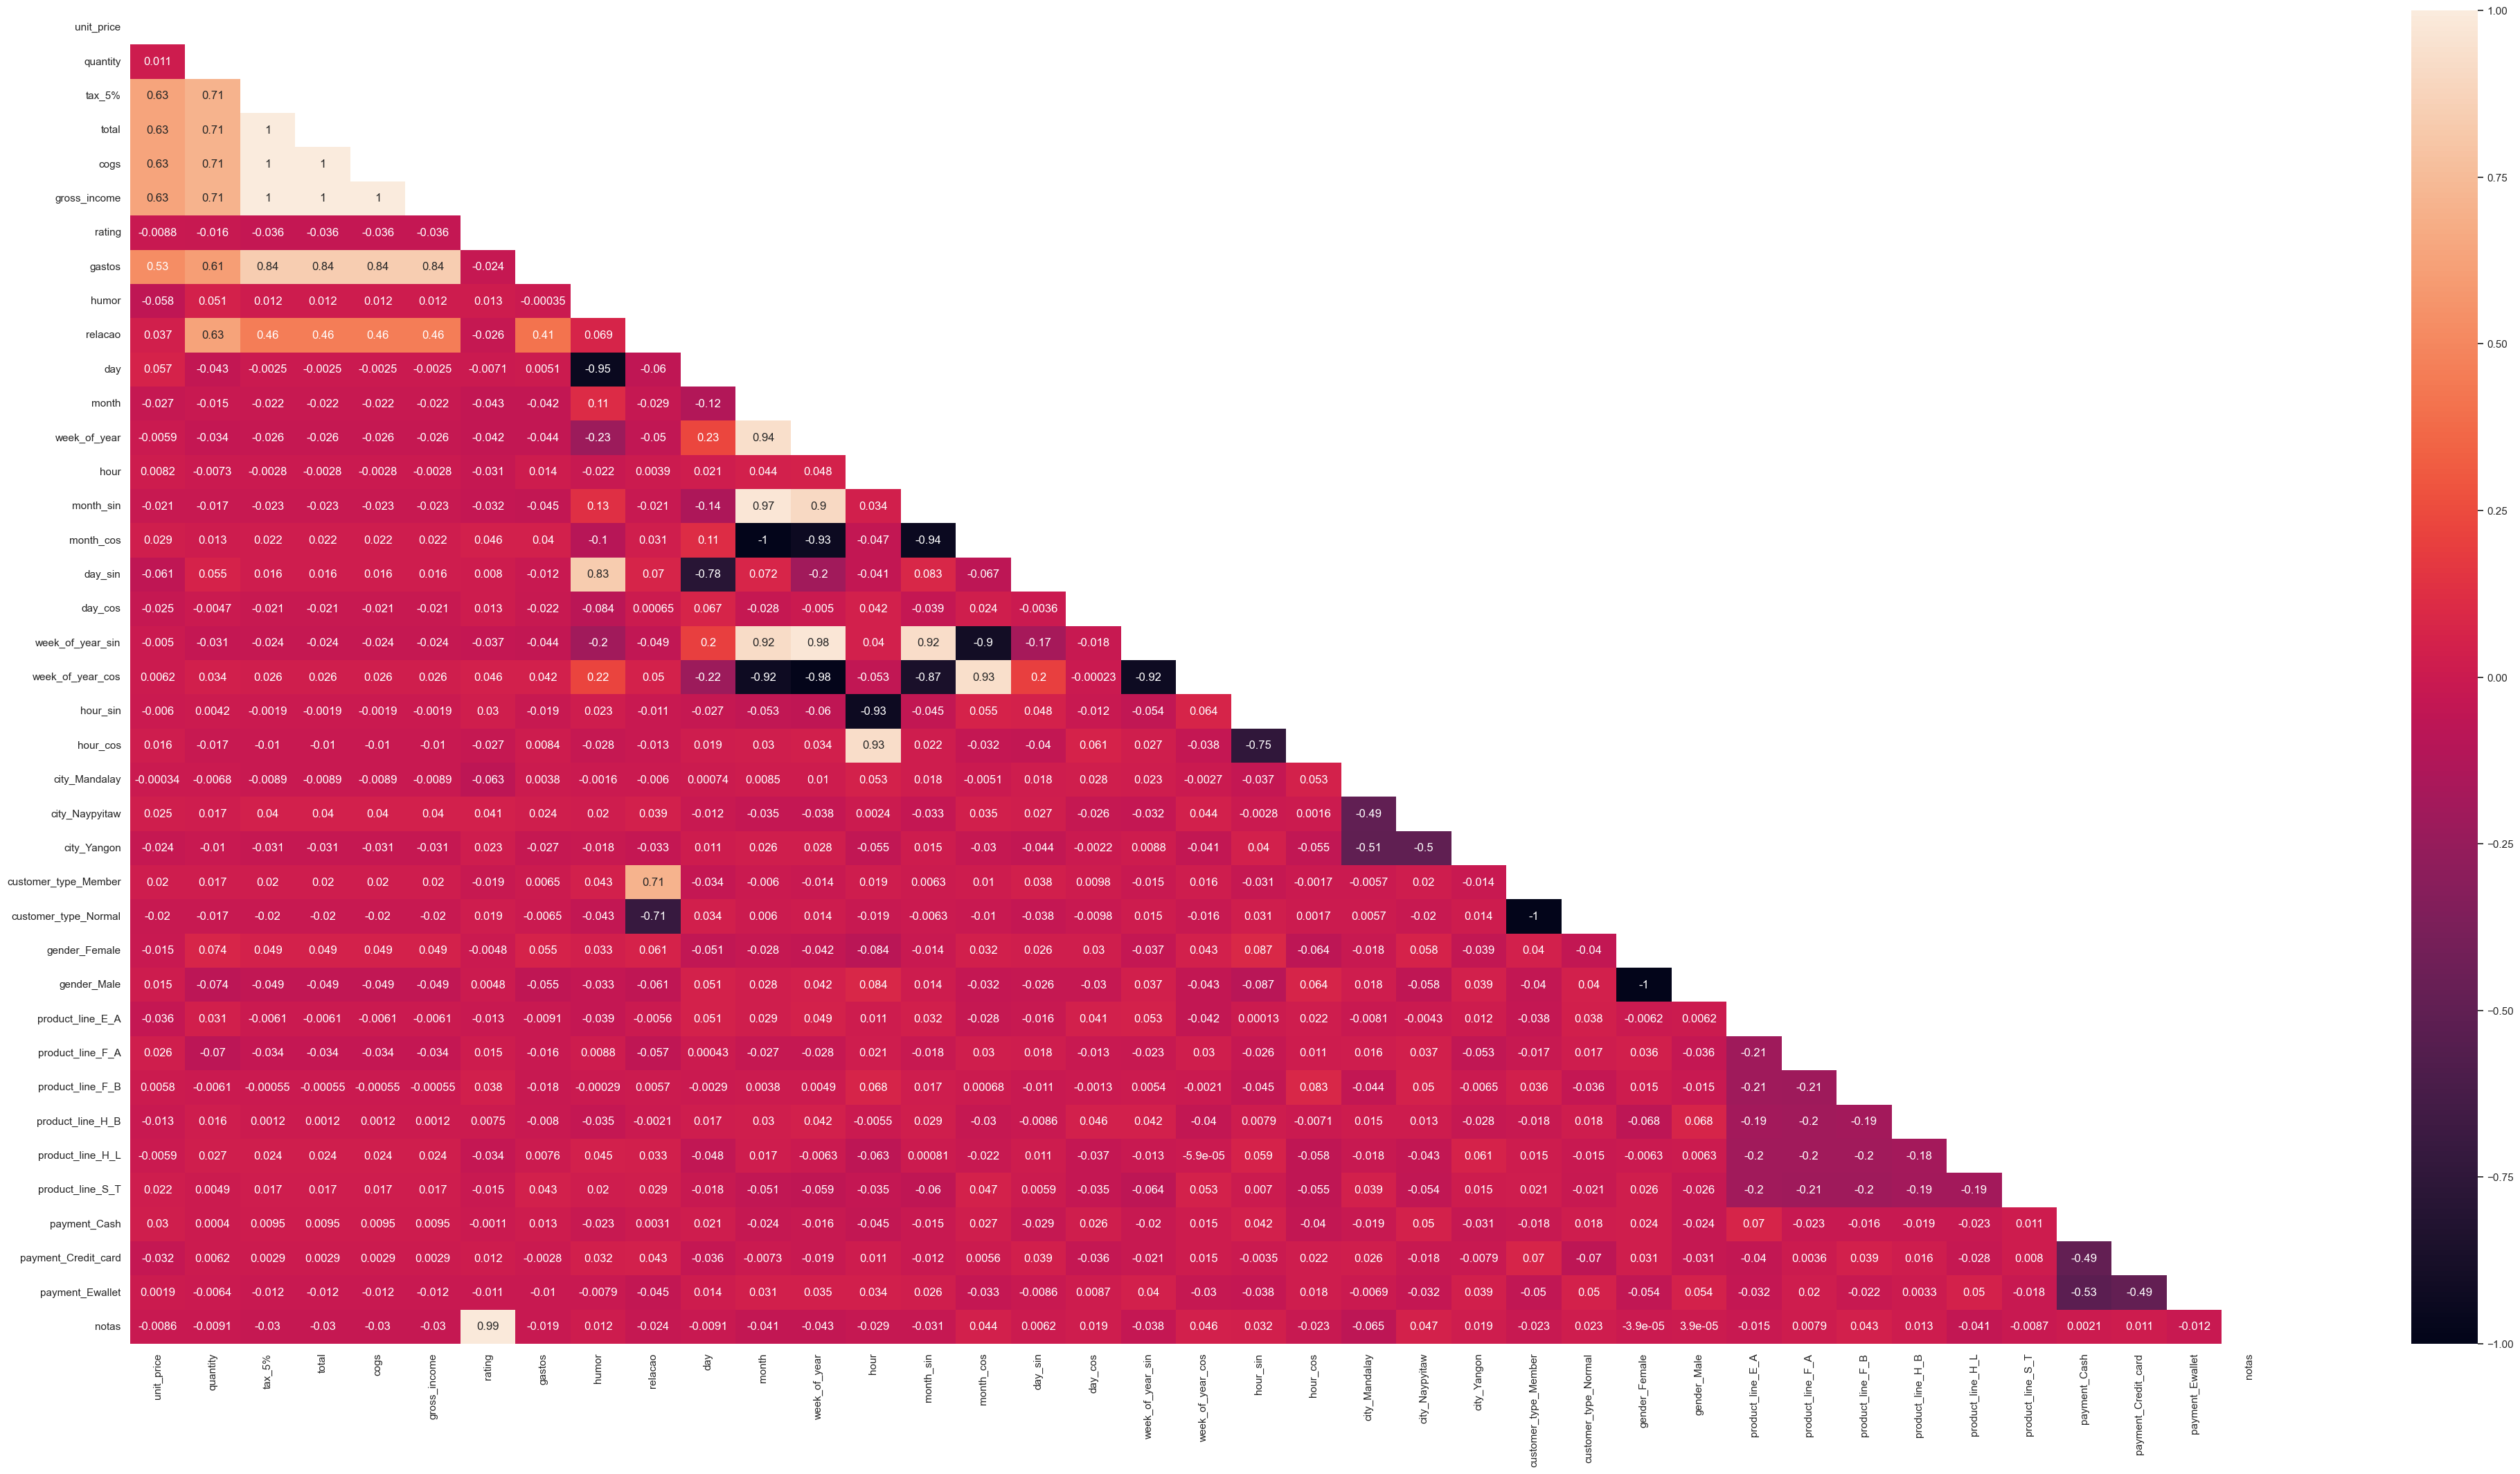

In [136]:
plt.rcParams['figure.figsize'] = [50,25] #configura tamanho de exibição do plot
corr = df8.corr(method='pearson') #corr recebe scores da correlação de Pearson
matrix = np.triu(corr) #matrix recebe matriz triangular dos scores de Pearson

with sns.axes_style("white"): #inicia plot com fundo branco
    sns.heatmap(corr, annot=True, mask=matrix); #plota matriz de correlações 

In [137]:
#Faz o split dos conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(df8.drop(['rating','notas'],axis=1), df8.notas, test_size=0.1, shuffle = True, random_state=20)

print(f'Dimensões:\n Variáveis explicativas para treinamento {X_train.shape}.' #exibe as dimensões dos conjuntos criados
     +  f'\n Variável resposta para treinamento {y_train.shape}.'  
     +  f'\n Variáveis explicativas para validação {X_test.shape}.' 
     +  f'\n Variável resposta para validação {y_test.shape}.')


Dimensões:
 Variáveis explicativas para treinamento (900, 37).
 Variável resposta para treinamento (900,).
 Variáveis explicativas para validação (100, 37).
 Variável resposta para validação (100,).


In [138]:
et = ExtraTreesRegressor(n_estimators=200, n_jobs=-1, random_state=20).fit(X_train, y_train) #et recebe o modelo ajustado com dados de treino 

yhat_et = et.predict(X_test) #yhat_et recebe as predições do modelos com os dados de teste

et_result = ml_error('Extra Trees', y_test, yhat_et) #et_result recebe retorno da função ml_model criada na seção 0.1
et_result #exibe valores de mlp_results

,Nome do Modelo,MAE,MAPE,RMSE,R-quadrado
0,Extra Trees,1.5974,0.278396,1.912514,-0.242597


A ideia não foi bem sucedida, uma vez que o resultado ruim se manteve.

###### Podemos tentar mudar a abordagem do aprendizado para classificação, onde as classes são as notas inteiras.

In [133]:
mlp = MLPClassifier(random_state=20, max_iter=500).fit(X_train, y_train) #mlp recebe o modelo ajustado com dados de treino 

yhat_mlp = mlp.predict(X_test) #yhat_mlp recebe as predições do modelos com os dados de teste

multilabel_confusion_matrix(y_test, yhat_mlp) # retorna as matrizes de confusão para as classes

array([[[68, 18],
        [13,  1]],

       [[58, 18],
        [17,  7]],

       [[75,  9],
        [14,  2]],

       [[64, 19],
        [12,  5]],

       [[78, 10],
        [10,  2]],

       [[78,  7],
        [13,  2]],

       [[98,  0],
        [ 2,  0]]], dtype=int64)

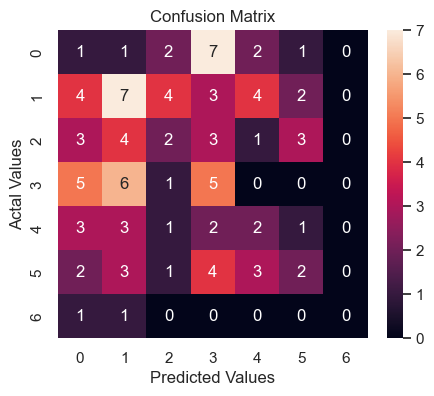

In [131]:
cm = confusion_matrix(y_test, yhat_mlp) #plota a matriz de confusão das classes, concatenada
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


Visivelmente podemos ver que o modelo não aprende a classificar de forma adequada

In [141]:
df_test = df6.copy()

###### Tentando predizer o faturamento bruto da empresa, em relação as outras variáveis, com diferentes modelos

In [164]:
#Divide o dataframe em outros 4 dataframes, 2 para treinamento e 2 para teste (separando a variável resposta das demais)
x_train, x_test, y_train, y_test = train_test_split(np.array(df_test.cogs).reshape(-1,1), df7.gross_income, test_size=0.25, shuffle = True, random_state=20) 

print(f'Dimensões:\n Variáveis explicativas para treinamento {x_train.shape}.' #exibe na tela as dimensões dos dataframes criados 
     +  f'\n Variável resposta para treinamento {y_train.shape}.' 
     +  f'\n Variáveis explicativas para validação {x_test.shape}.' 
     +  f'\n Variável resposta para validação {y_test.shape}.')

Dimensões:
 Variáveis explicativas para treinamento (750, 1).
 Variável resposta para treinamento (750,).
 Variáveis explicativas para validação (250, 1).
 Variável resposta para validação (250,).


In [165]:
et = ExtraTreesRegressor(n_estimators=200, n_jobs=-1, random_state=20).fit(x_train, y_train) #et recebe o modelo ajustado com dados de treino 

yhat_et = et.predict(x_test) #yhat_et recebe as predições do modelos com os dados de teste

et_result = ml_error('Extra Trees', y_test, yhat_et) #et_result recebe retorno da função ml_model criada na seção 0.1
et_result #exibe valores de mlp_results

,Nome do Modelo,MAE,MAPE,RMSE,R-quadrado
0,Extra Trees,0.130331,7.296698e+11,0.171124,0.431491


Vemos que o modelos Extra Trees conseguiu aprender facilmente a predizer o faturamento total, com apenas a variável de custo por produto

In [154]:
#Divide o dataframe em outros 4 dataframes, 2 para treinamento e 2 para teste (separando a variável resposta das demais)
x_train, x_test, y_train, y_test = train_test_split(df_test[['unit_price','quantity']], df7.gross_income, test_size=0.25, shuffle = True, random_state=20) 

print(f'Dimensões:\n Variáveis explicativas para treinamento {x_train.shape}.' #exibe na tela as dimensões dos dataframes criados 
     +  f'\n Variável resposta para treinamento {y_train.shape}.' 
     +  f'\n Variáveis explicativas para validação {x_test.shape}.' 
     +  f'\n Variável resposta para validação {y_test.shape}.')

Dimensões:
 Variáveis explicativas para treinamento (750, 2).
 Variável resposta para treinamento (750,).
 Variáveis explicativas para validação (250, 2).
 Variável resposta para validação (250,).


In [157]:
rf = RandomForestRegressor().fit(x_train, y_train) #rfrecebe o modelo ajustado com dados de treino 

yhat_rf = rf.predict(x_test) #yhat_rf recebe as predições do modelos com os dados de teste

rf_result = ml_error('Extra Trees', y_test, yhat_rf) #rf_result recebe retorno da função ml_model criada na seção 0.1
rf_result #exibe valores de mlp_results

,Nome do Modelo,MAE,MAPE,RMSE,R-quadrado
0,Extra Trees,0.003809,4.034420e+10,0.005812,0.999344


O modelo Random Forest também consegue se ajustar super bem para predizer o faturamento bruto recebendo apenas o valor da quantidade comprada e o preço por unidade

## 9.0 Conclusão

- O dataset fornecido estava em boas condições em relação limpeza dos dados, não havia observações faltantes nem desbalanceamento nas variáveis o que facilitou as etapas iniciais do projeto.

- Na descritiva e exploratória dos dados foi possível ter um entendimento sobre a natureza do problema e das eventuais adversidades que os modelos encontrariam ao ter que aprender a explicar a variável resposta. 
- Como as variáveis explicativas apresentavam bastante semelhança entre si dificultou a extração de caracterísricas, uma vez que qualquer característica extraída seria muito semelhante à inicial e continuaria com baixa correlação com a resposta. Uma solução possível seria obter novas fontes de dados para acrescentar no dataset a fim de correlacionar bem com nosso alvo. 

- Muitas variáveis eram categóricas, fazendo com que fosse realizada as tranformações. Junto à isso, a padronização dos dados também foi realizada para que os modelos não sofressem por viés de algumas variáveis específicas.

- Da modelagem, o maior desafio foi de fato a própria aprendizagem onde não foi possível estabelecer padrões explicativos para a variável resposta. Ao meu ver, os modelos ainda se saíram bem tendo em vista as métricas variando um ponto e meio na avaliação sendo que o ajuste estava muito inadequado. 

- Como visto, para outras variáveis a predição é muito confiável dado que os modelos se ajustam bem. Isso foi possível ver na exploratória dos dados onde analisamos que as demais features tinham boa correlação e apresentavam padrões em suas dispersões pareadas.

- Mesmo tentando reescalar a variável resposta ou até mesmo mudar a abordagem da aprendizagem para classificação, não foi possível estabelecer explicação para a variável de avaliação da empresa. Com isso, seria necessário uma reunião com os times para uma conversa acerca das possíveis soluções sugeridas. Ou até mesmo tentar explicar a satisfação do cliente por um outro método, assumindo que a forma de avaliação atual pode estar prejudicada de alguma forma.